# Comparison of the Different Experimental Setups
- number of initial chains = 7
- merge after every 2 steps

In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
from utils import *
from matplotlib.patches import Patch

In [2]:
# All experiments relevant for this notebook for the 1b model
experiments_1b = ["b1_2", "n1_2", "n2_2", "n3_2", "m1_2", "m2_2", "m3_2"]

# For 4b model
experiments_4b = [f"big_{a}" for a in experiments_1b]

In [3]:
print("1B MODEL")
complete_folders_1b = check_existing_folders(experiments_1b)
print("\n\n\n\n4B MODEL")
complete_folders_4b = check_existing_folders(experiments_4b)

1B MODEL

Folders with all required files:
['b1_2', 'n1_2', 'n2_2', 'n3_2', 'm1_2', 'm2_2', 'm3_2']




4B MODEL
ERROR big_n2_2 folder does not exist

Folders with all required files:
['big_b1_2', 'big_n1_2', 'big_n3_2', 'big_m1_2', 'big_m2_2', 'big_m3_2']


## Analysis of Baseline
### Avg/Median Number of Reasoning Steps

Average number of reasoning steps: 5.02
Median number of reasoning steps: 5.00


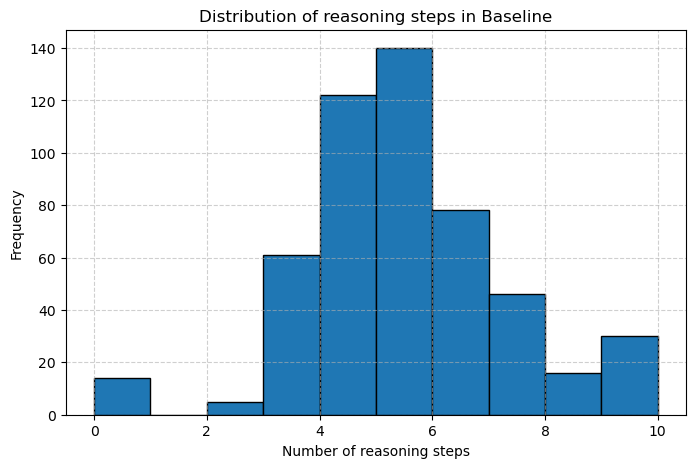

In [4]:
reasoning_lengths = []
p = os.path.join(path_to_experiments, "b1_2", "b1_2.jsonl")
with open(p, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        reasoning = data.get("reasoning", "")
        lines = reasoning.strip().split("\n")
        n_lines = len([l for l in lines if l.strip()])
        reasoning_lengths.append(n_lines)

avg_length = sum(reasoning_lengths) / len(reasoning_lengths)
print(f"Average number of reasoning steps: {avg_length:.2f}")
median_length = np.median(reasoning_lengths)
print(f"Median number of reasoning steps: {median_length:.2f}")

# Plot the distribution of reasoning lengths
binning = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
reasoning_lengths_array = [[l] for l in reasoning_lengths]
binned = binning.fit_transform(reasoning_lengths_array).flatten()

plt.figure(figsize=(8, 5))
plt.hist(reasoning_lengths, bins=range(min(reasoning_lengths), max(reasoning_lengths)+2), edgecolor='black')
plt.xlabel("Number of reasoning steps")
plt.ylabel("Frequency")
plt.title("Distribution of reasoning steps in Baseline")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Report of Evaluation Results

In [5]:
# For paper
plt.rcParams.update({
    "font.size": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 22,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
    "legend.title_fontsize": 22,
    "figure.dpi": 300
})

In [6]:
groups = [
    ("B1", ["b1_2"]),
    ("N1      M1", ["n1_2", "m1_2"]),
    ("N2      M2", ["n2_2", "m2_2"]),
    ("N3      M3", ["n3_2", "m3_2"])
]

color_map = {
    "b1_2": "#d1495b",  # none
    "n1_2": "#edae49",  # entailment-based
    "n2_2": "#edae49",
    "n3_2": "#edae49",
    "m1_2": "#00798c",  # embedding-based
    "m2_2": "#00798c",
    "m3_2": "#00798c"
}

def create_plot(metric_file_name="_em_results.jsonl", metric_column=None, ylabel="Score", title="", metric_name="predicted"):
    """
    Specify metric_column if using the Roscoe metric. Otherwise, set it to None.
    """
    group_labels = []
    all_scores = []
    all_colors = []

    for label, exps in groups:
        group_labels.append(label)
        group_scores = []
        group_col = []
        for exp in exps:
            if metric_column is None:
                score = compute_accuracy(exp, metric_file_name, metric_name)
            else:
                score = compute_roscoe_metric(exp, metric_file_name, metric_column)
            group_scores.append(score)
            group_col.append(color_map[exp])
        all_scores.append(group_scores)
        all_colors.append(group_col)

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    x = range(len(groups))

    for i, (scores, colors) in enumerate(zip(all_scores, all_colors)):
        for j, (score, color) in enumerate(zip(scores, colors)):
            offset = -bar_width / 2 if len(scores) == 2 else 0
            offset += j * bar_width if len(scores) == 2 else 0
            ax.bar(i + offset, score, width=bar_width, color=color)

    ax.set_xticks(range(len(groups)))
    ax.set_xticklabels(group_labels)
    ax.set_xlabel("Experiment")
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, 1)
    ax.set_title(title)

    legend_elements = [
        Patch(facecolor="#d1495b", label="None"),
        Patch(facecolor="#edae49", label="Entailment-based"),
        Patch(facecolor="#00798c", label="Embedding-based")
    ]
    ax.legend(handles=legend_elements, title="Clustering Method")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

### Accuracy of the final answer

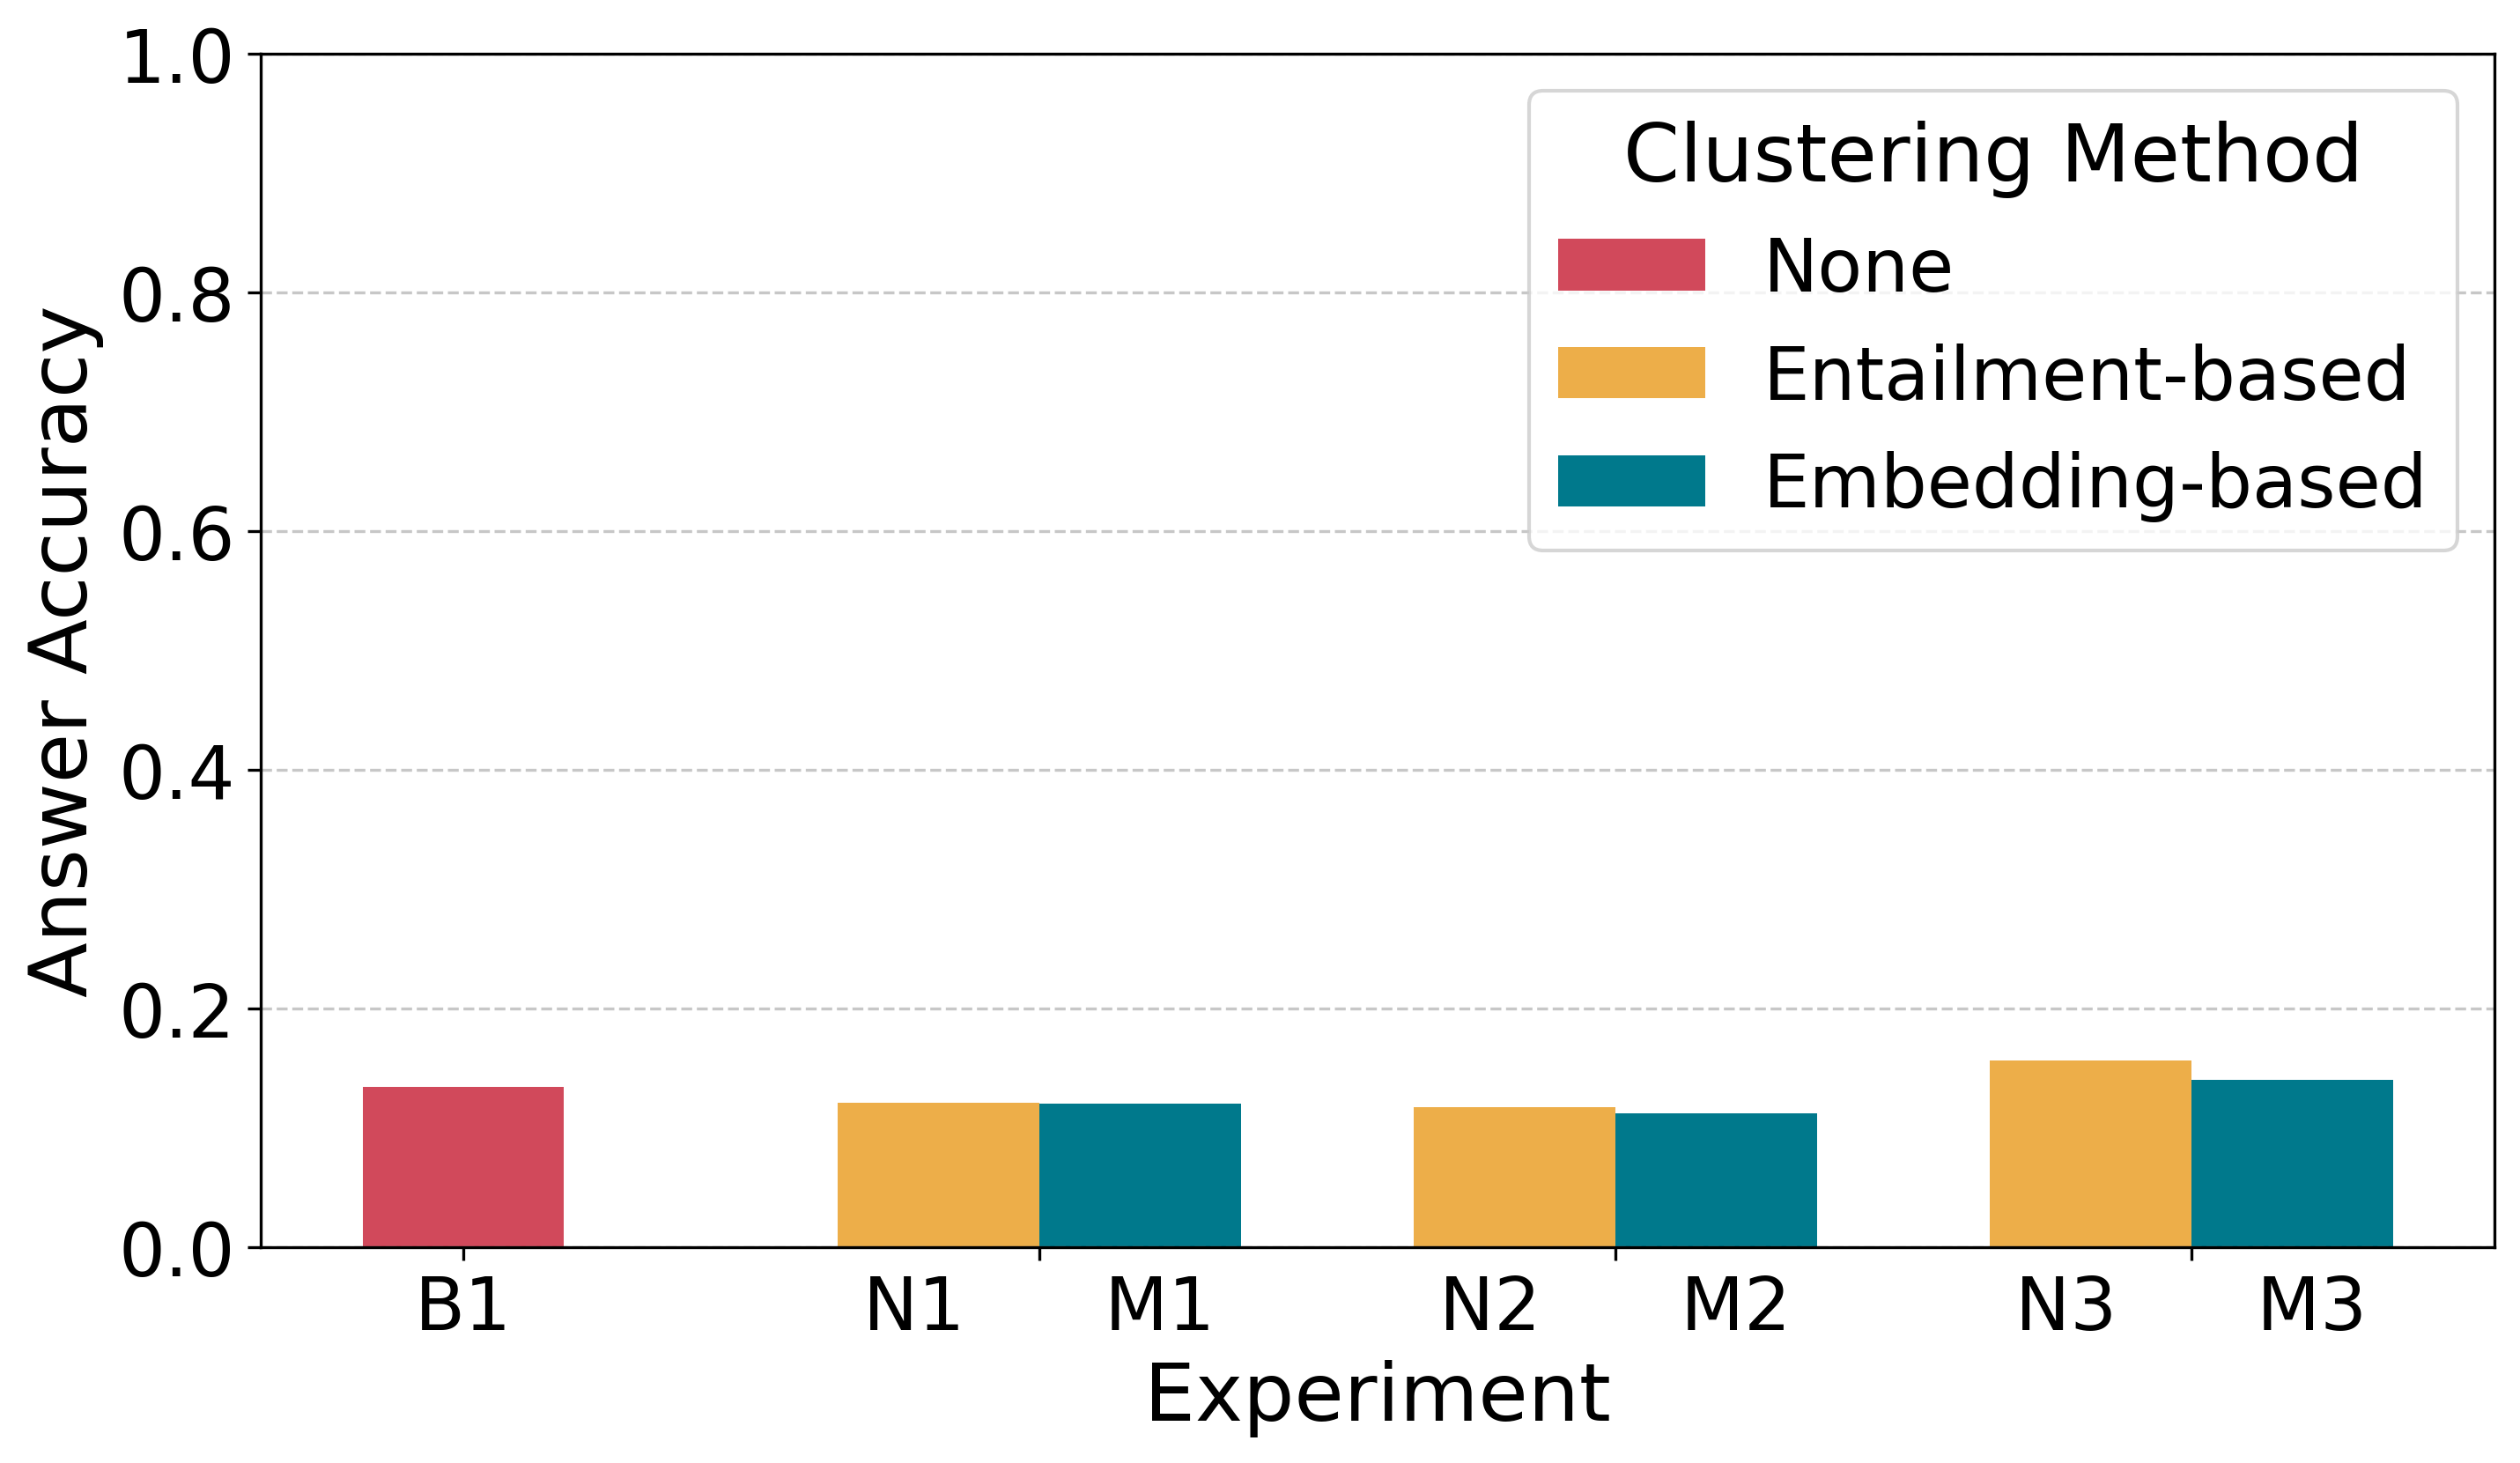

In [7]:
create_plot(metric_file_name="_em_results.jsonl", ylabel="Answer Accuracy", title="")

### Accuracy of the reasoning process

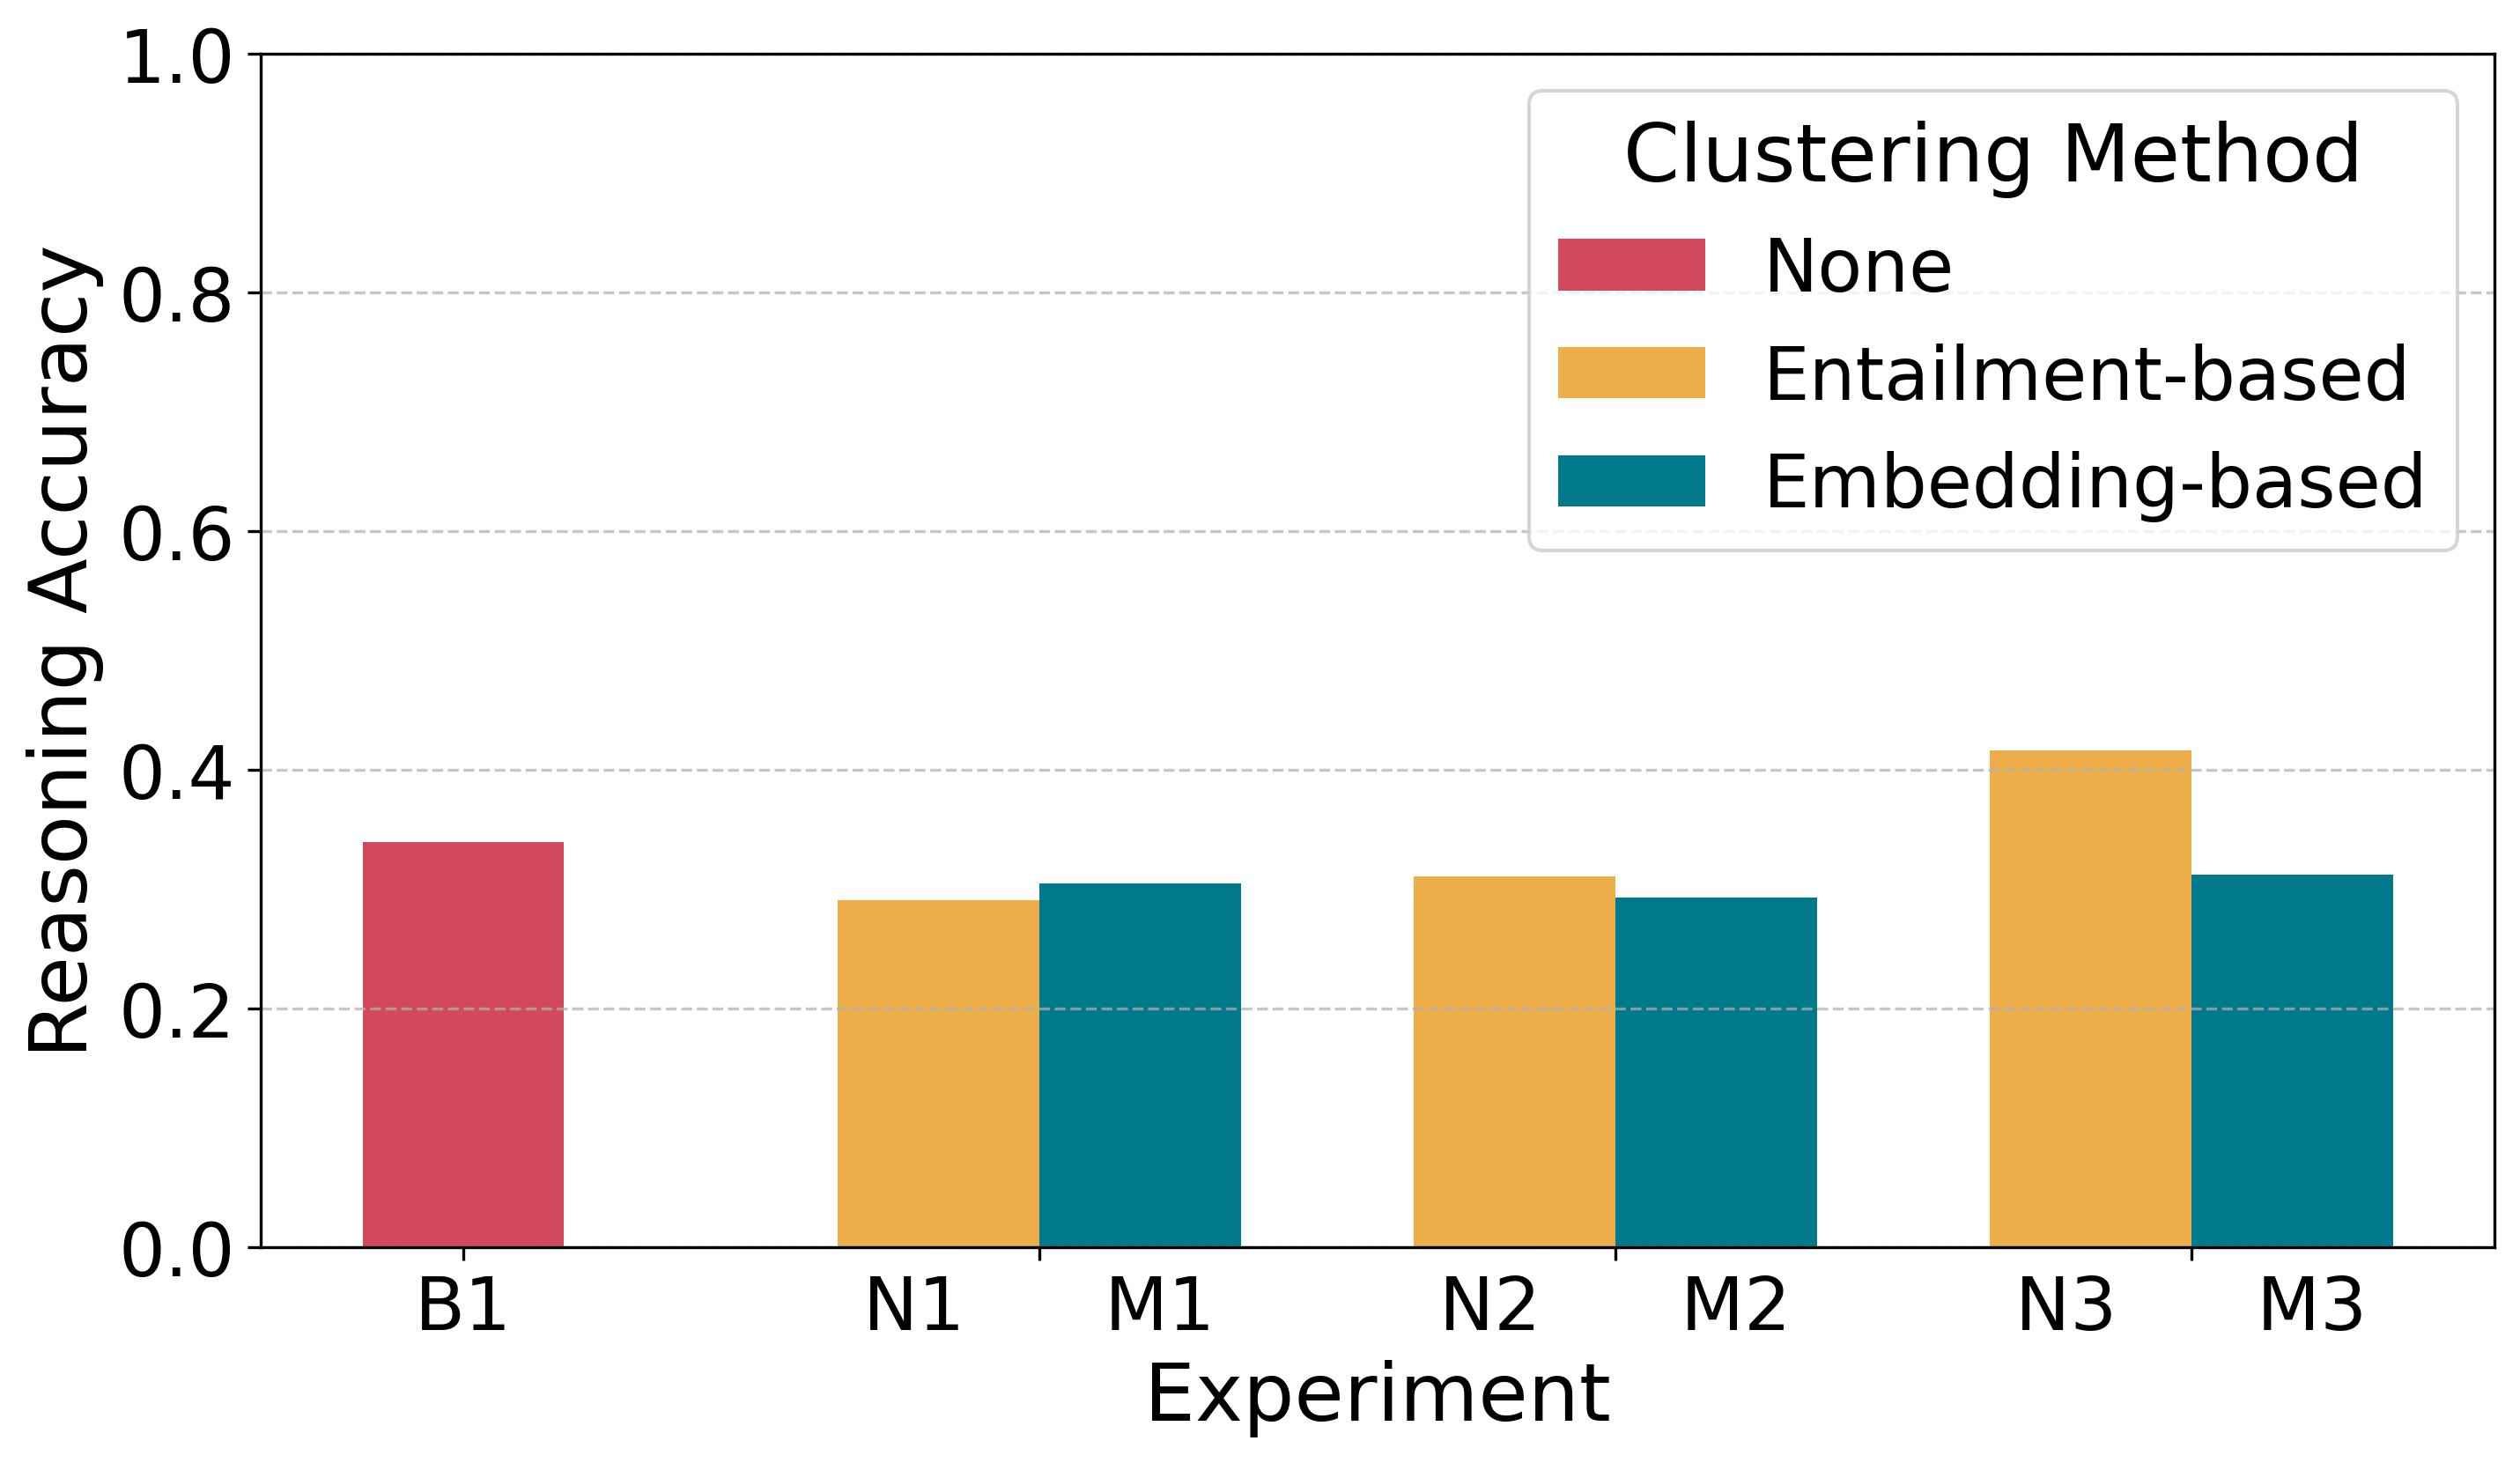

In [8]:
create_plot(metric_file_name="_llm_comparison_results.jsonl", ylabel="Reasoning Accuracy", title="")

### Faithfulness of the final chain

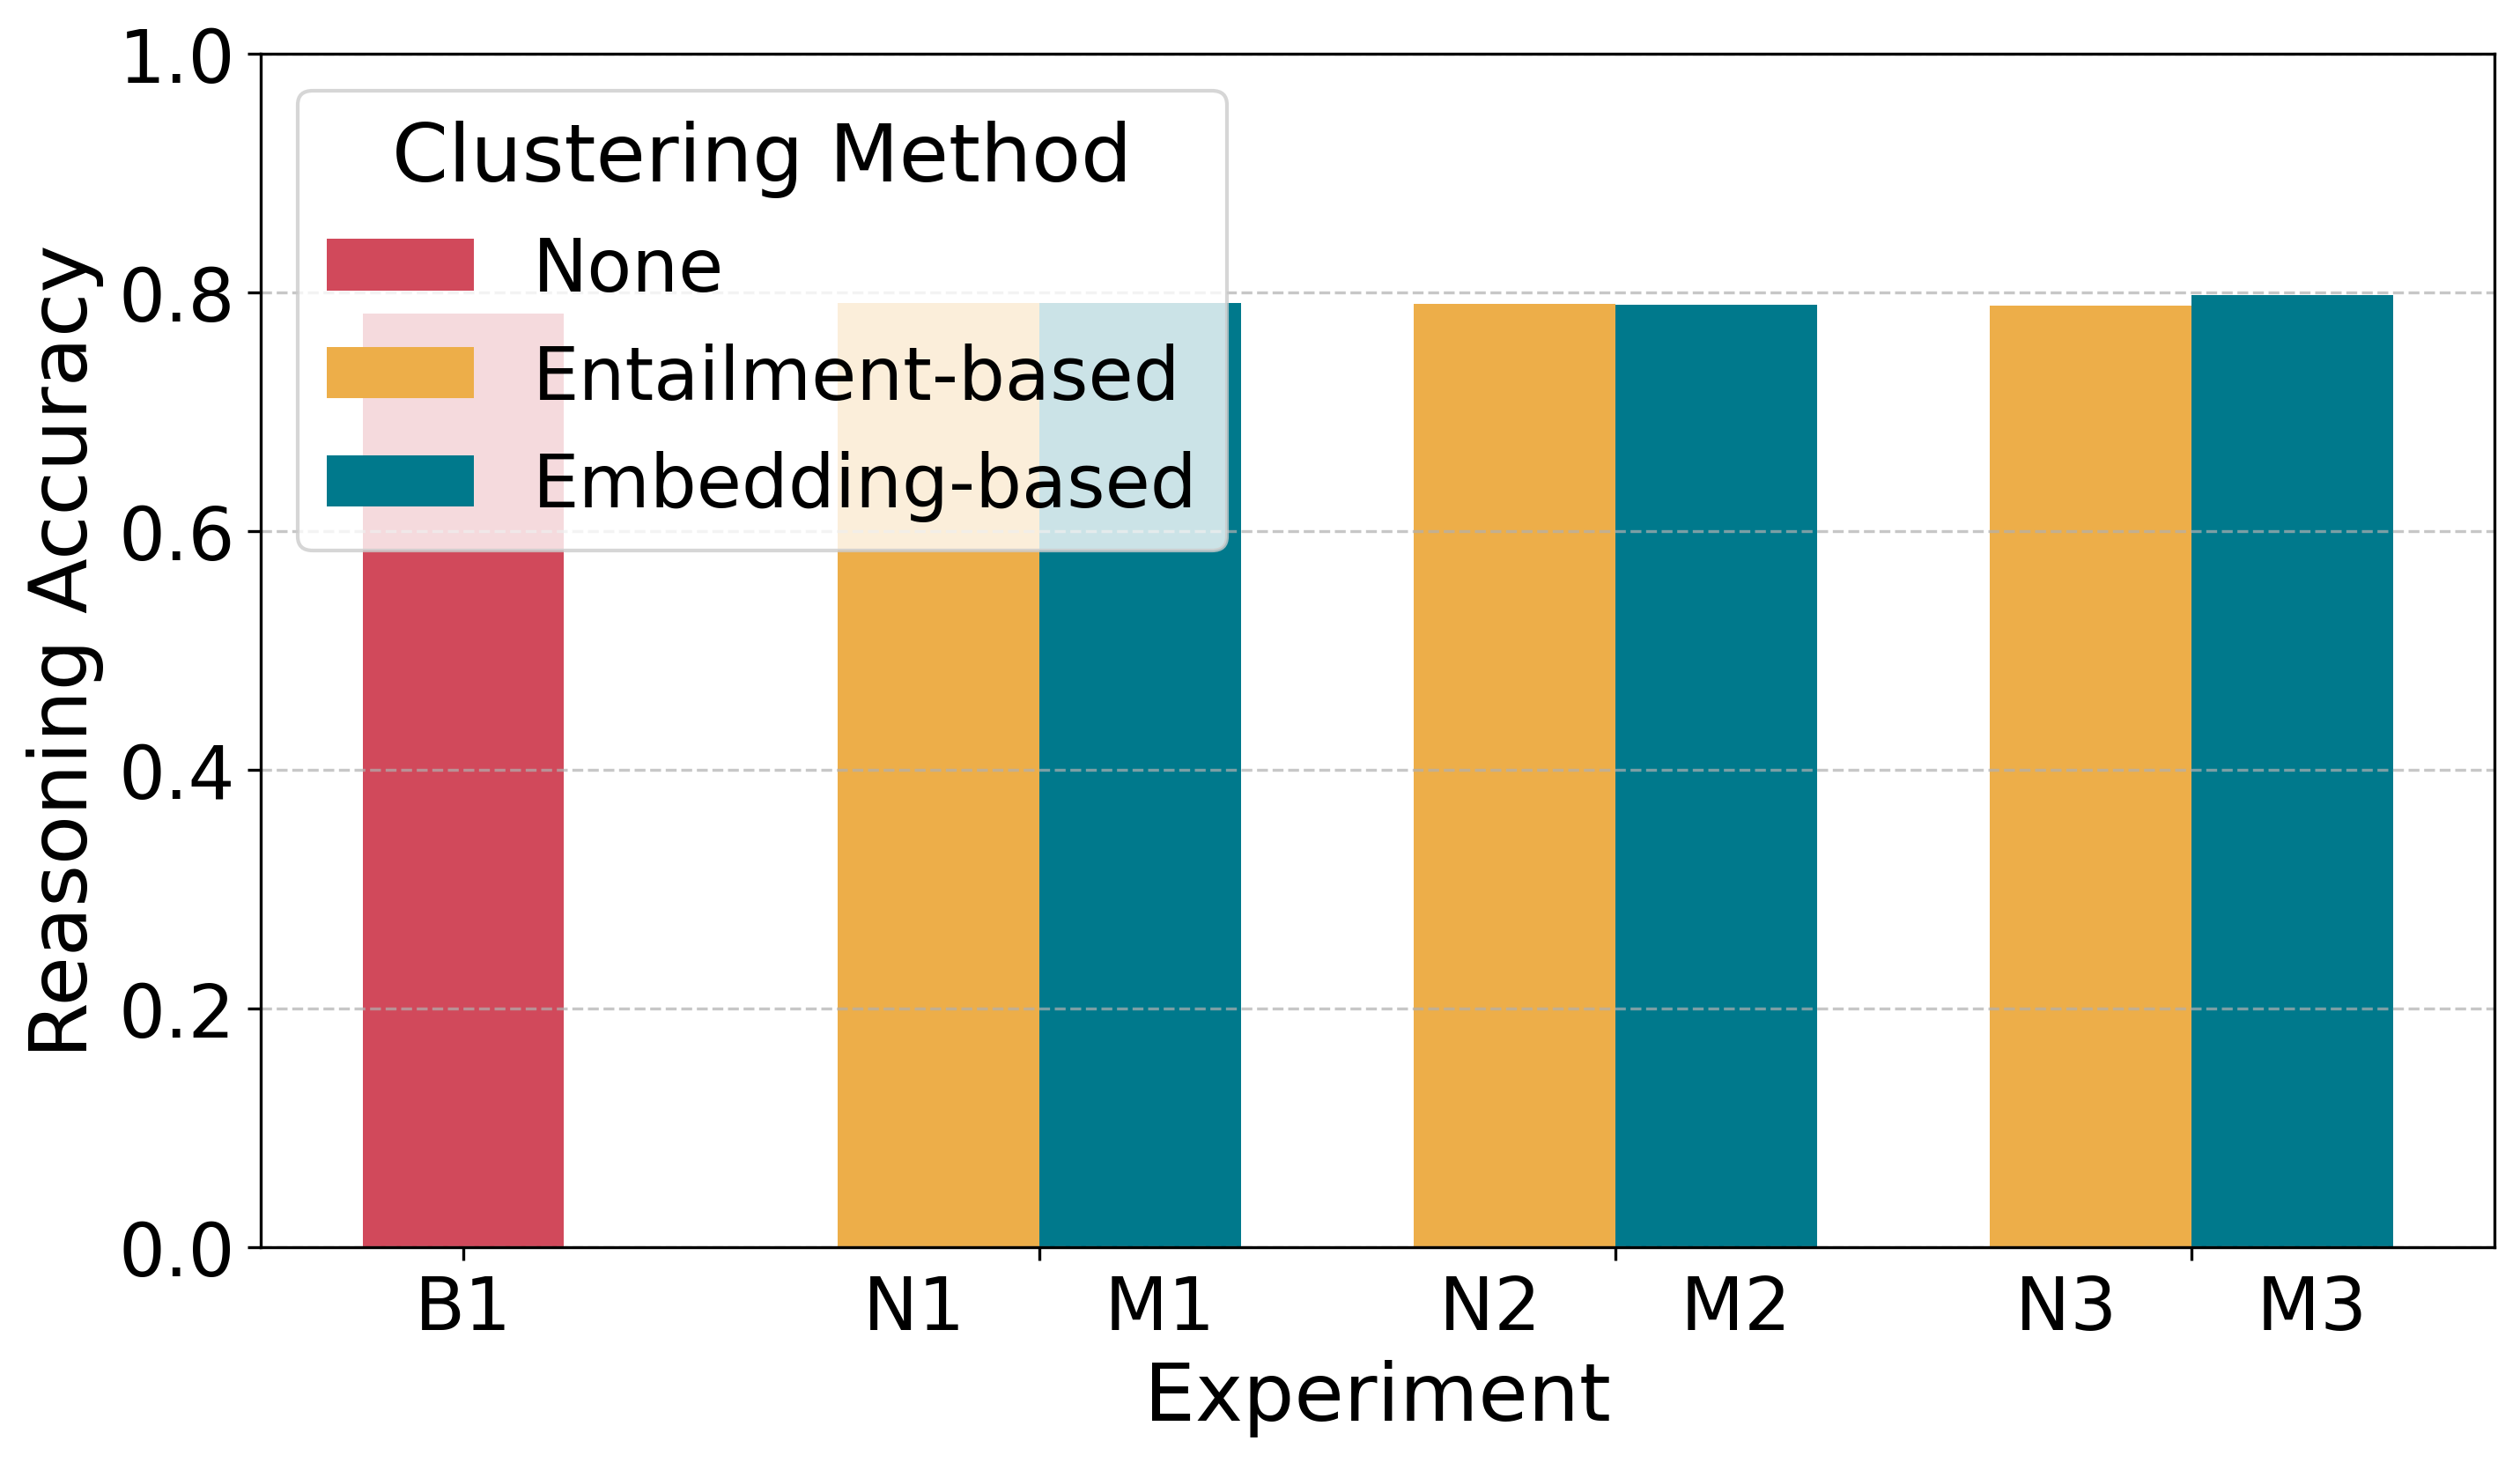

In [9]:
create_plot(metric_file_name="_roscoe_results.tsv", metric_column="faithfulness", ylabel="Reasoning Accuracy", title="")

### Other metrics

#### Correctness of Reasoning Process

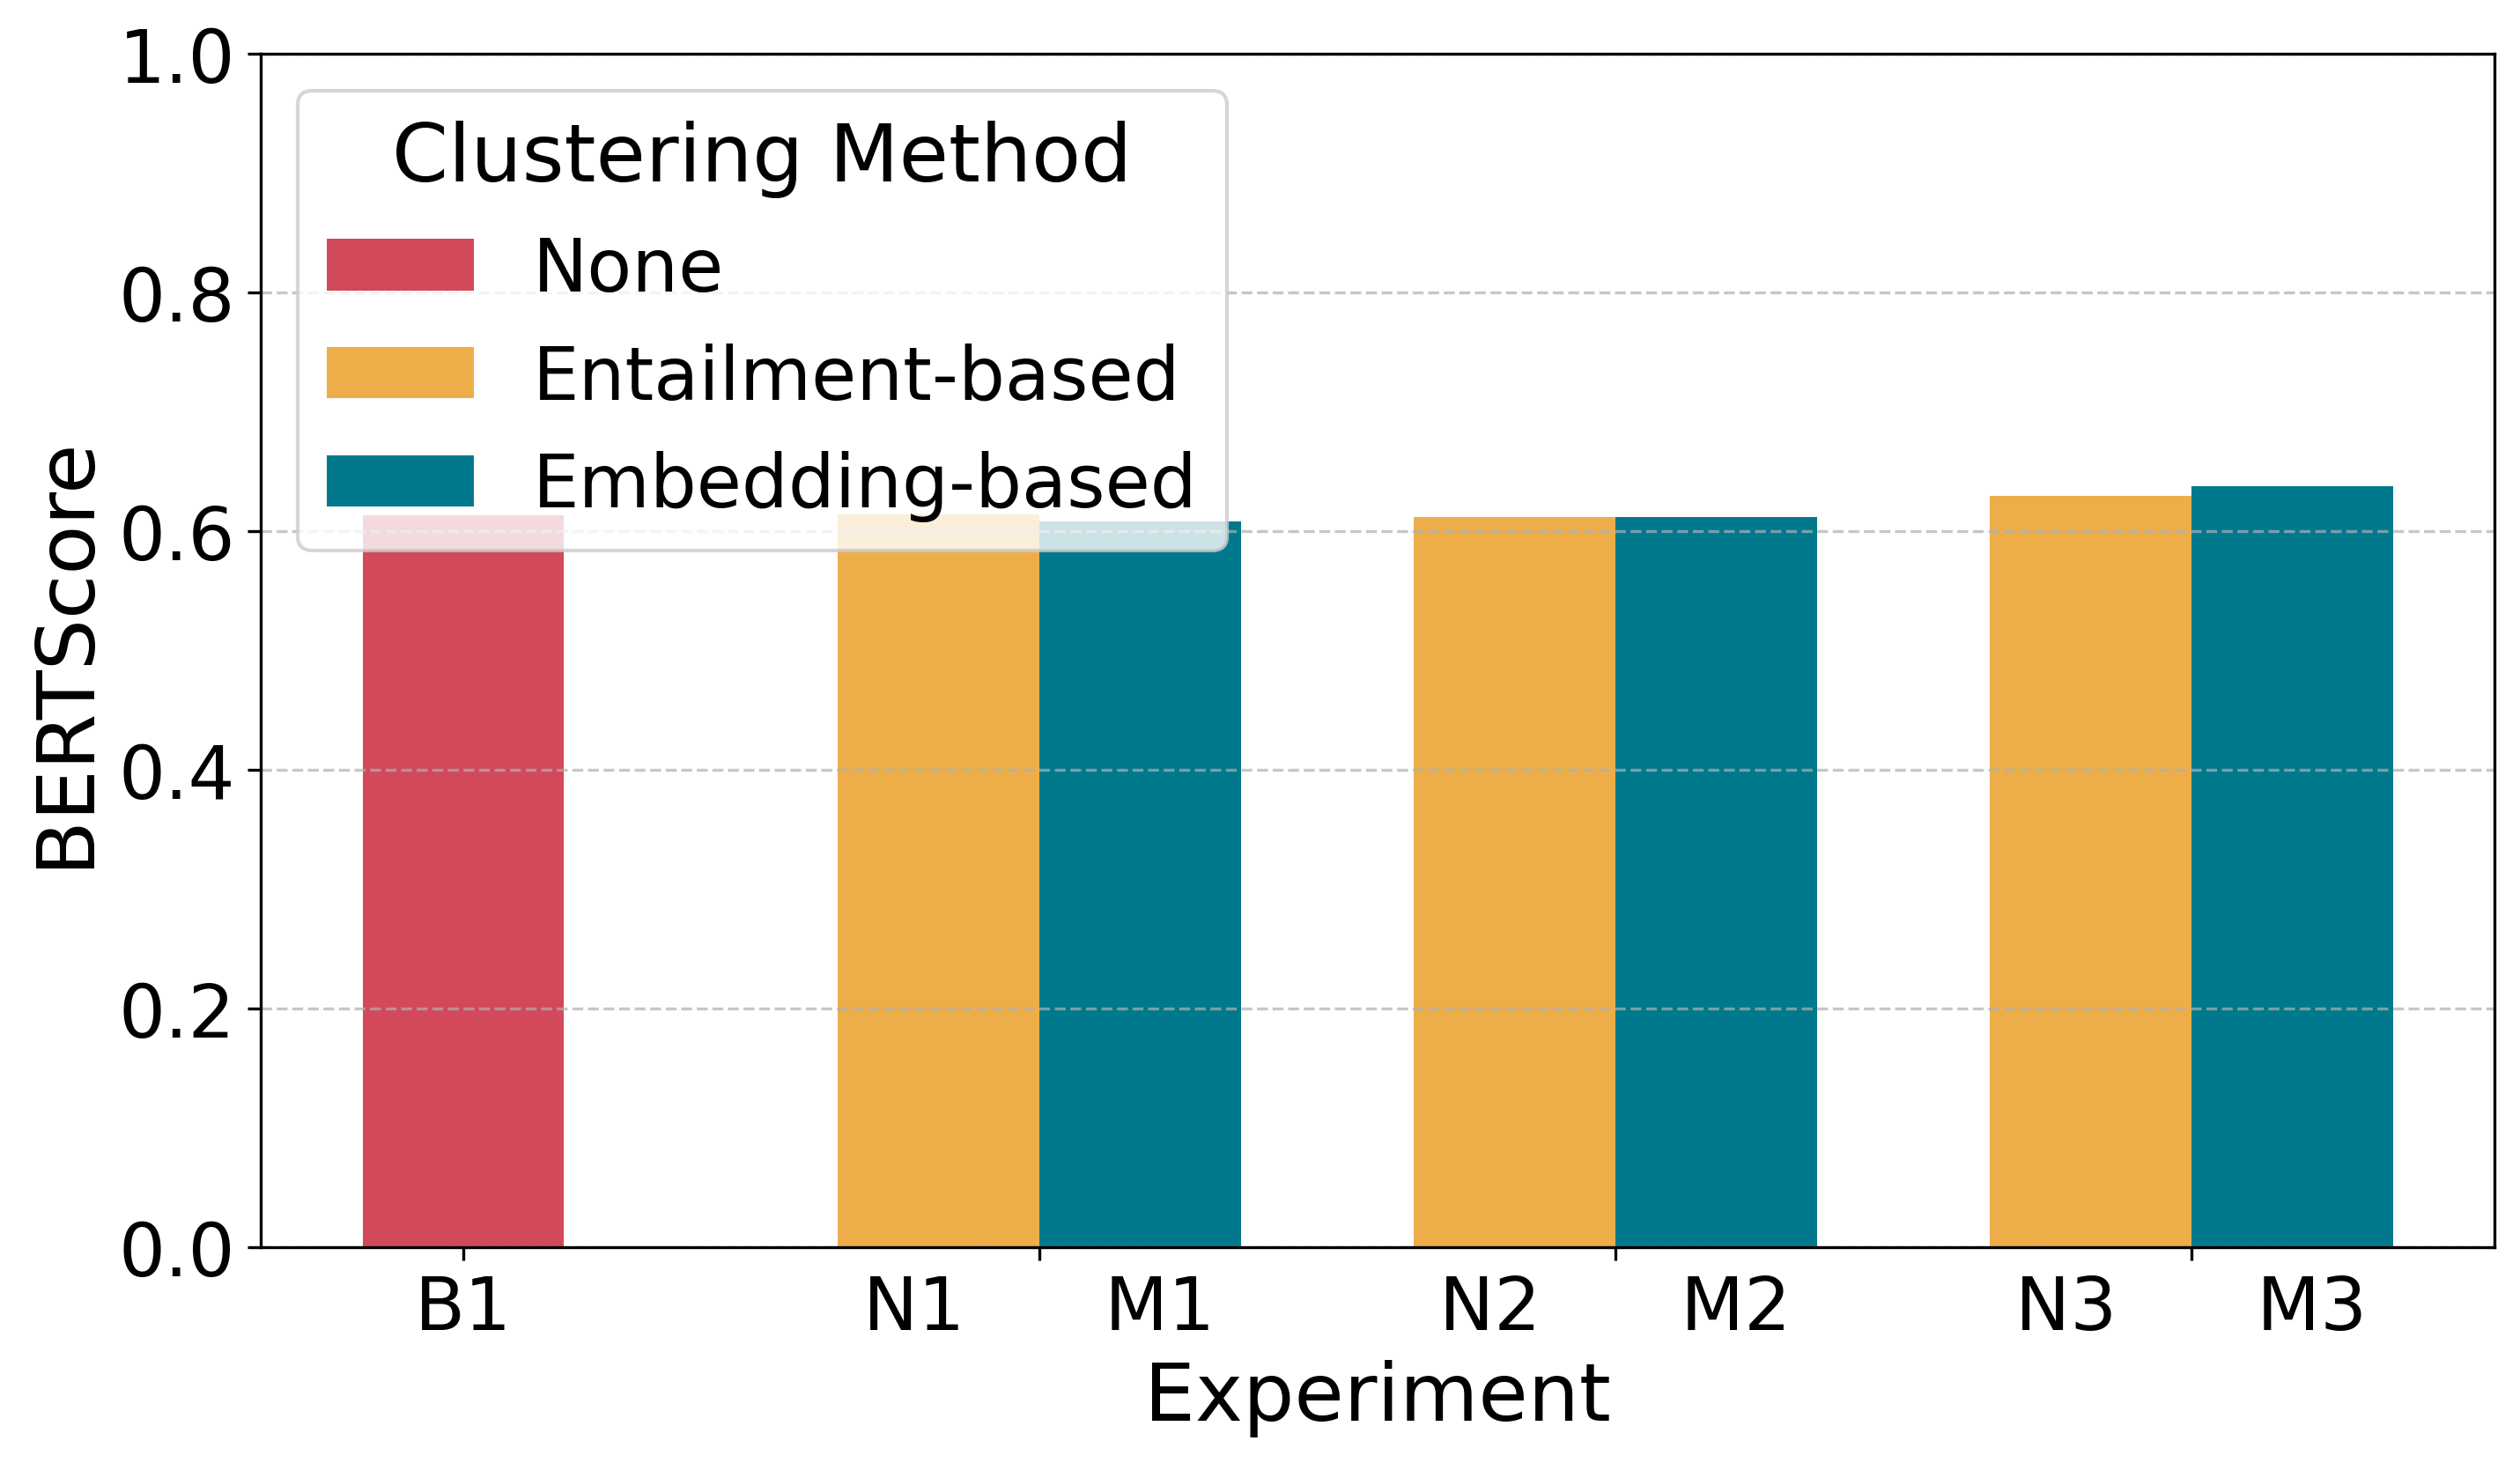

In [10]:
create_plot(metric_file_name="_bert_score_results.jsonl", ylabel="BERTScore", title="", metric_name="similarity")

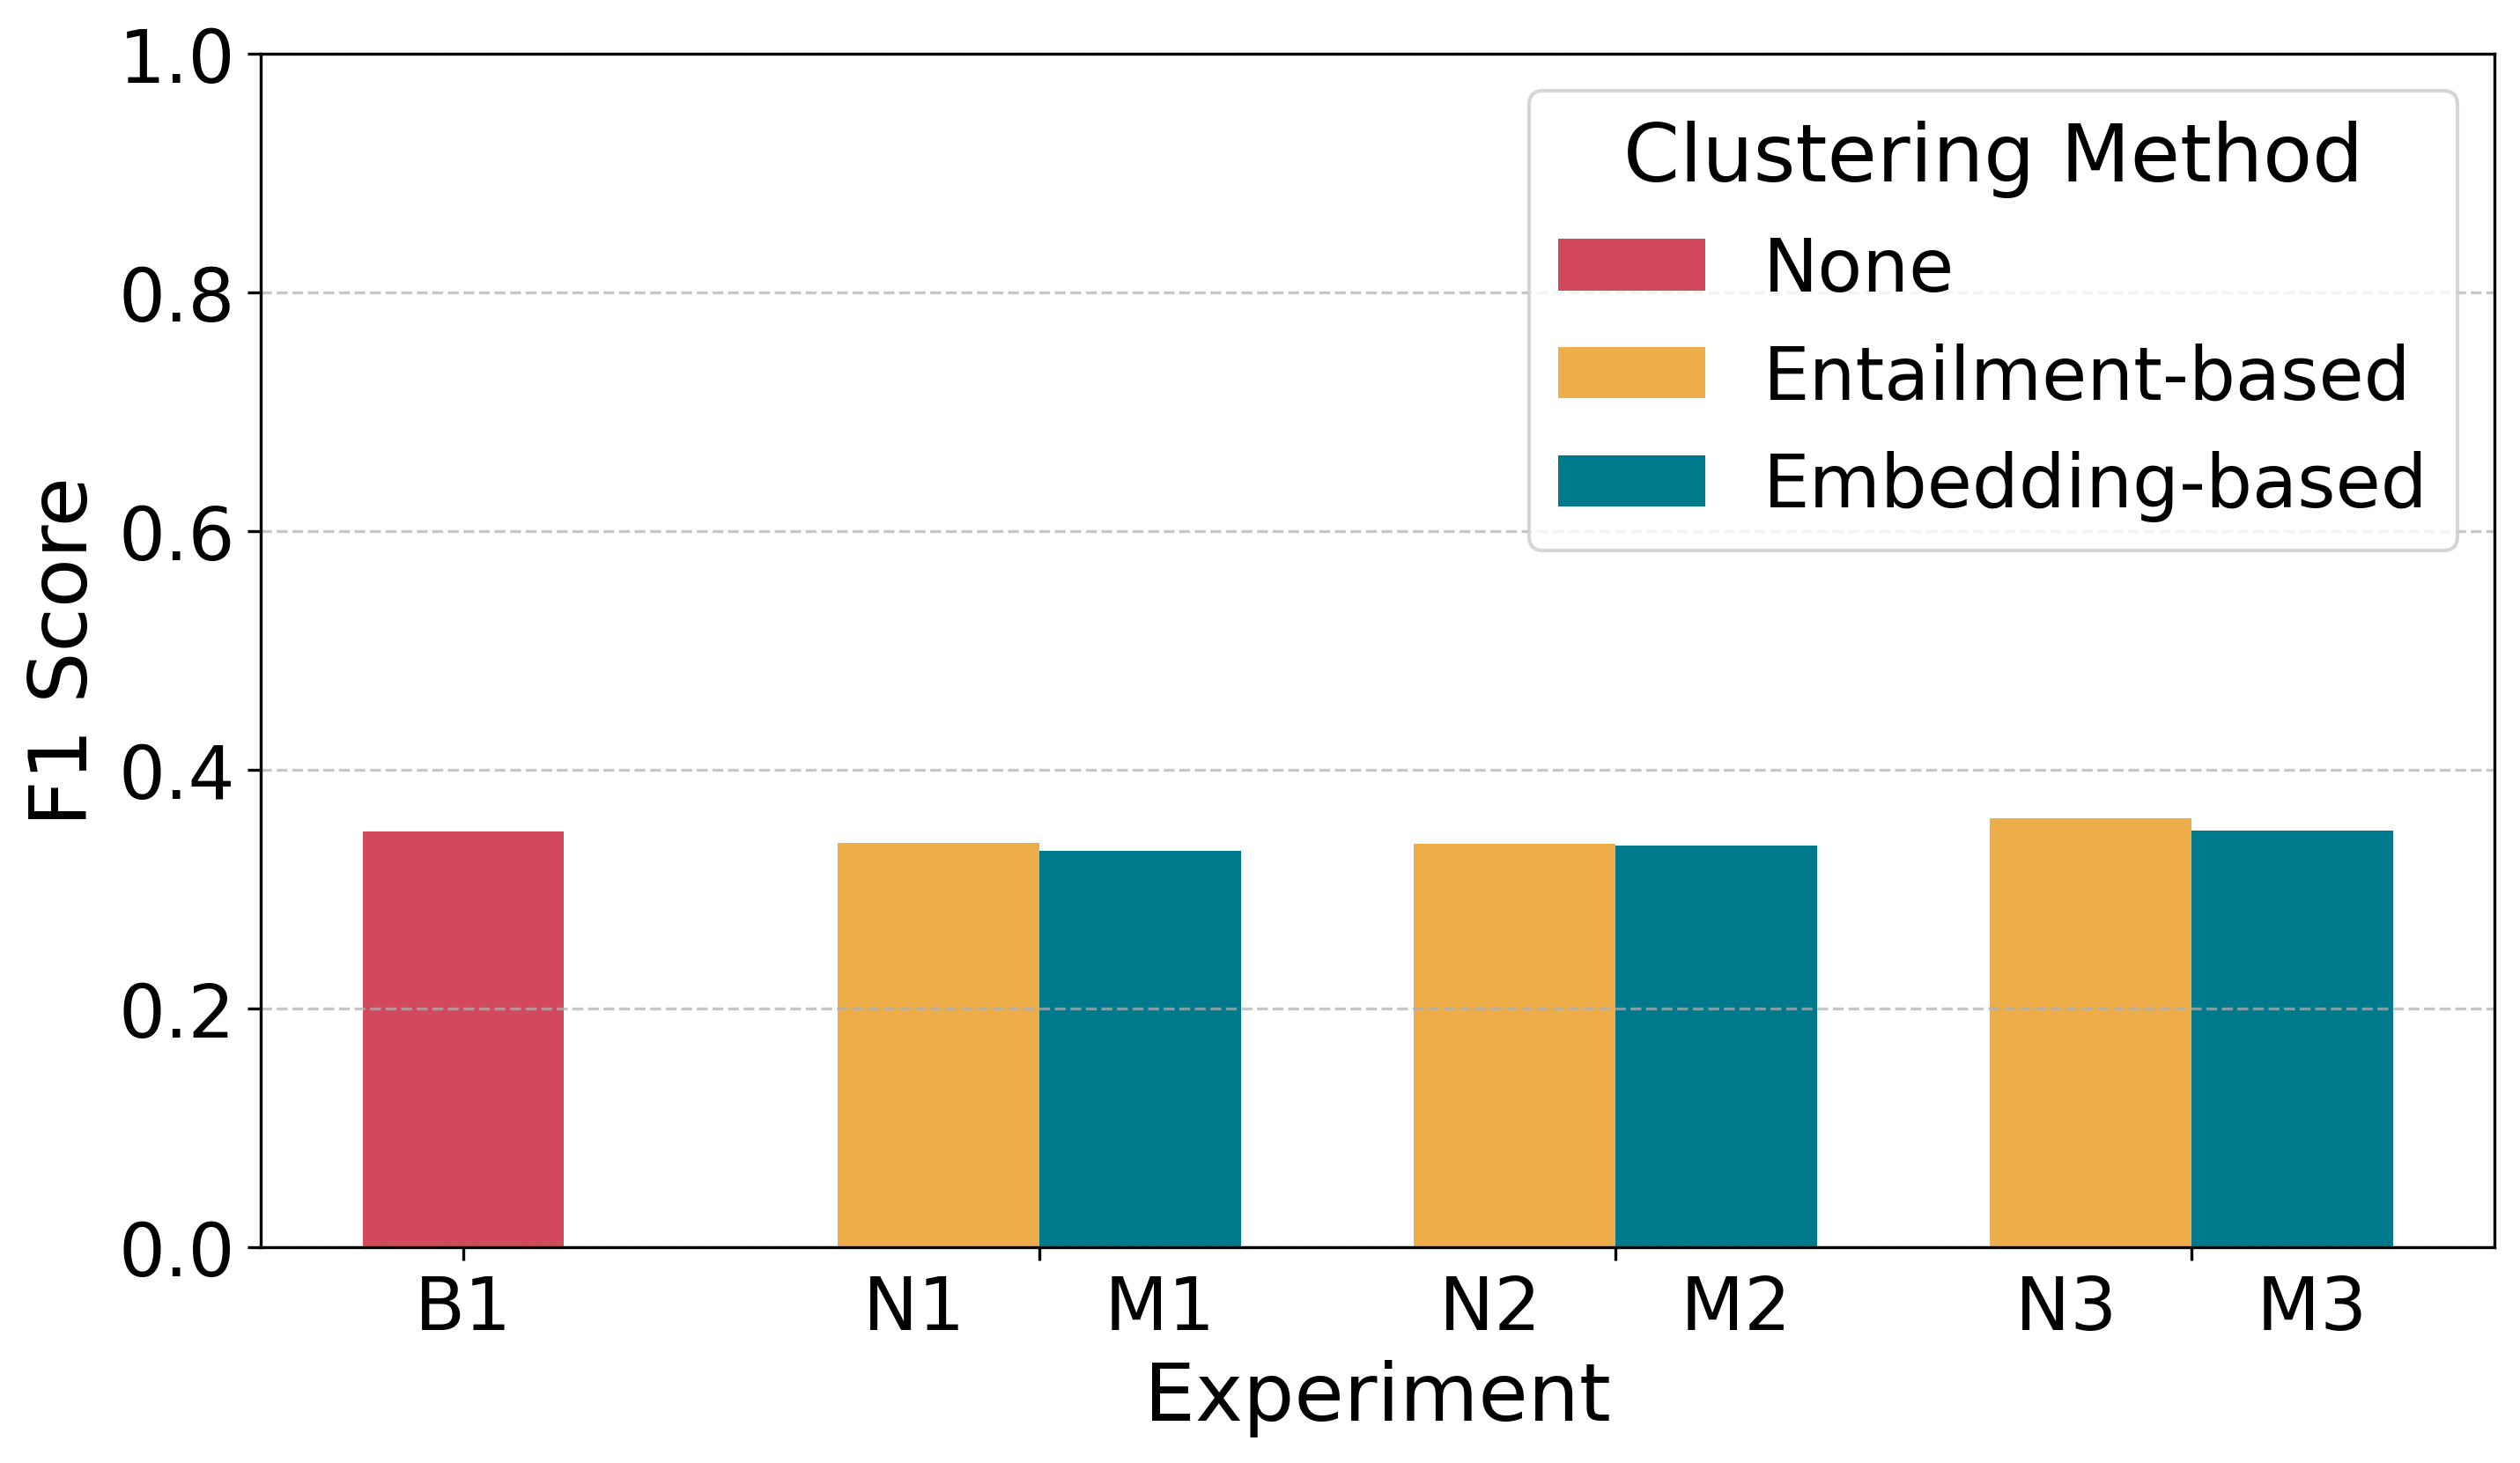

In [11]:
create_plot(metric_file_name="_f1_results.jsonl", ylabel="F1 Score", title="", metric_name="f1")

#### Chain Consistency and Quality

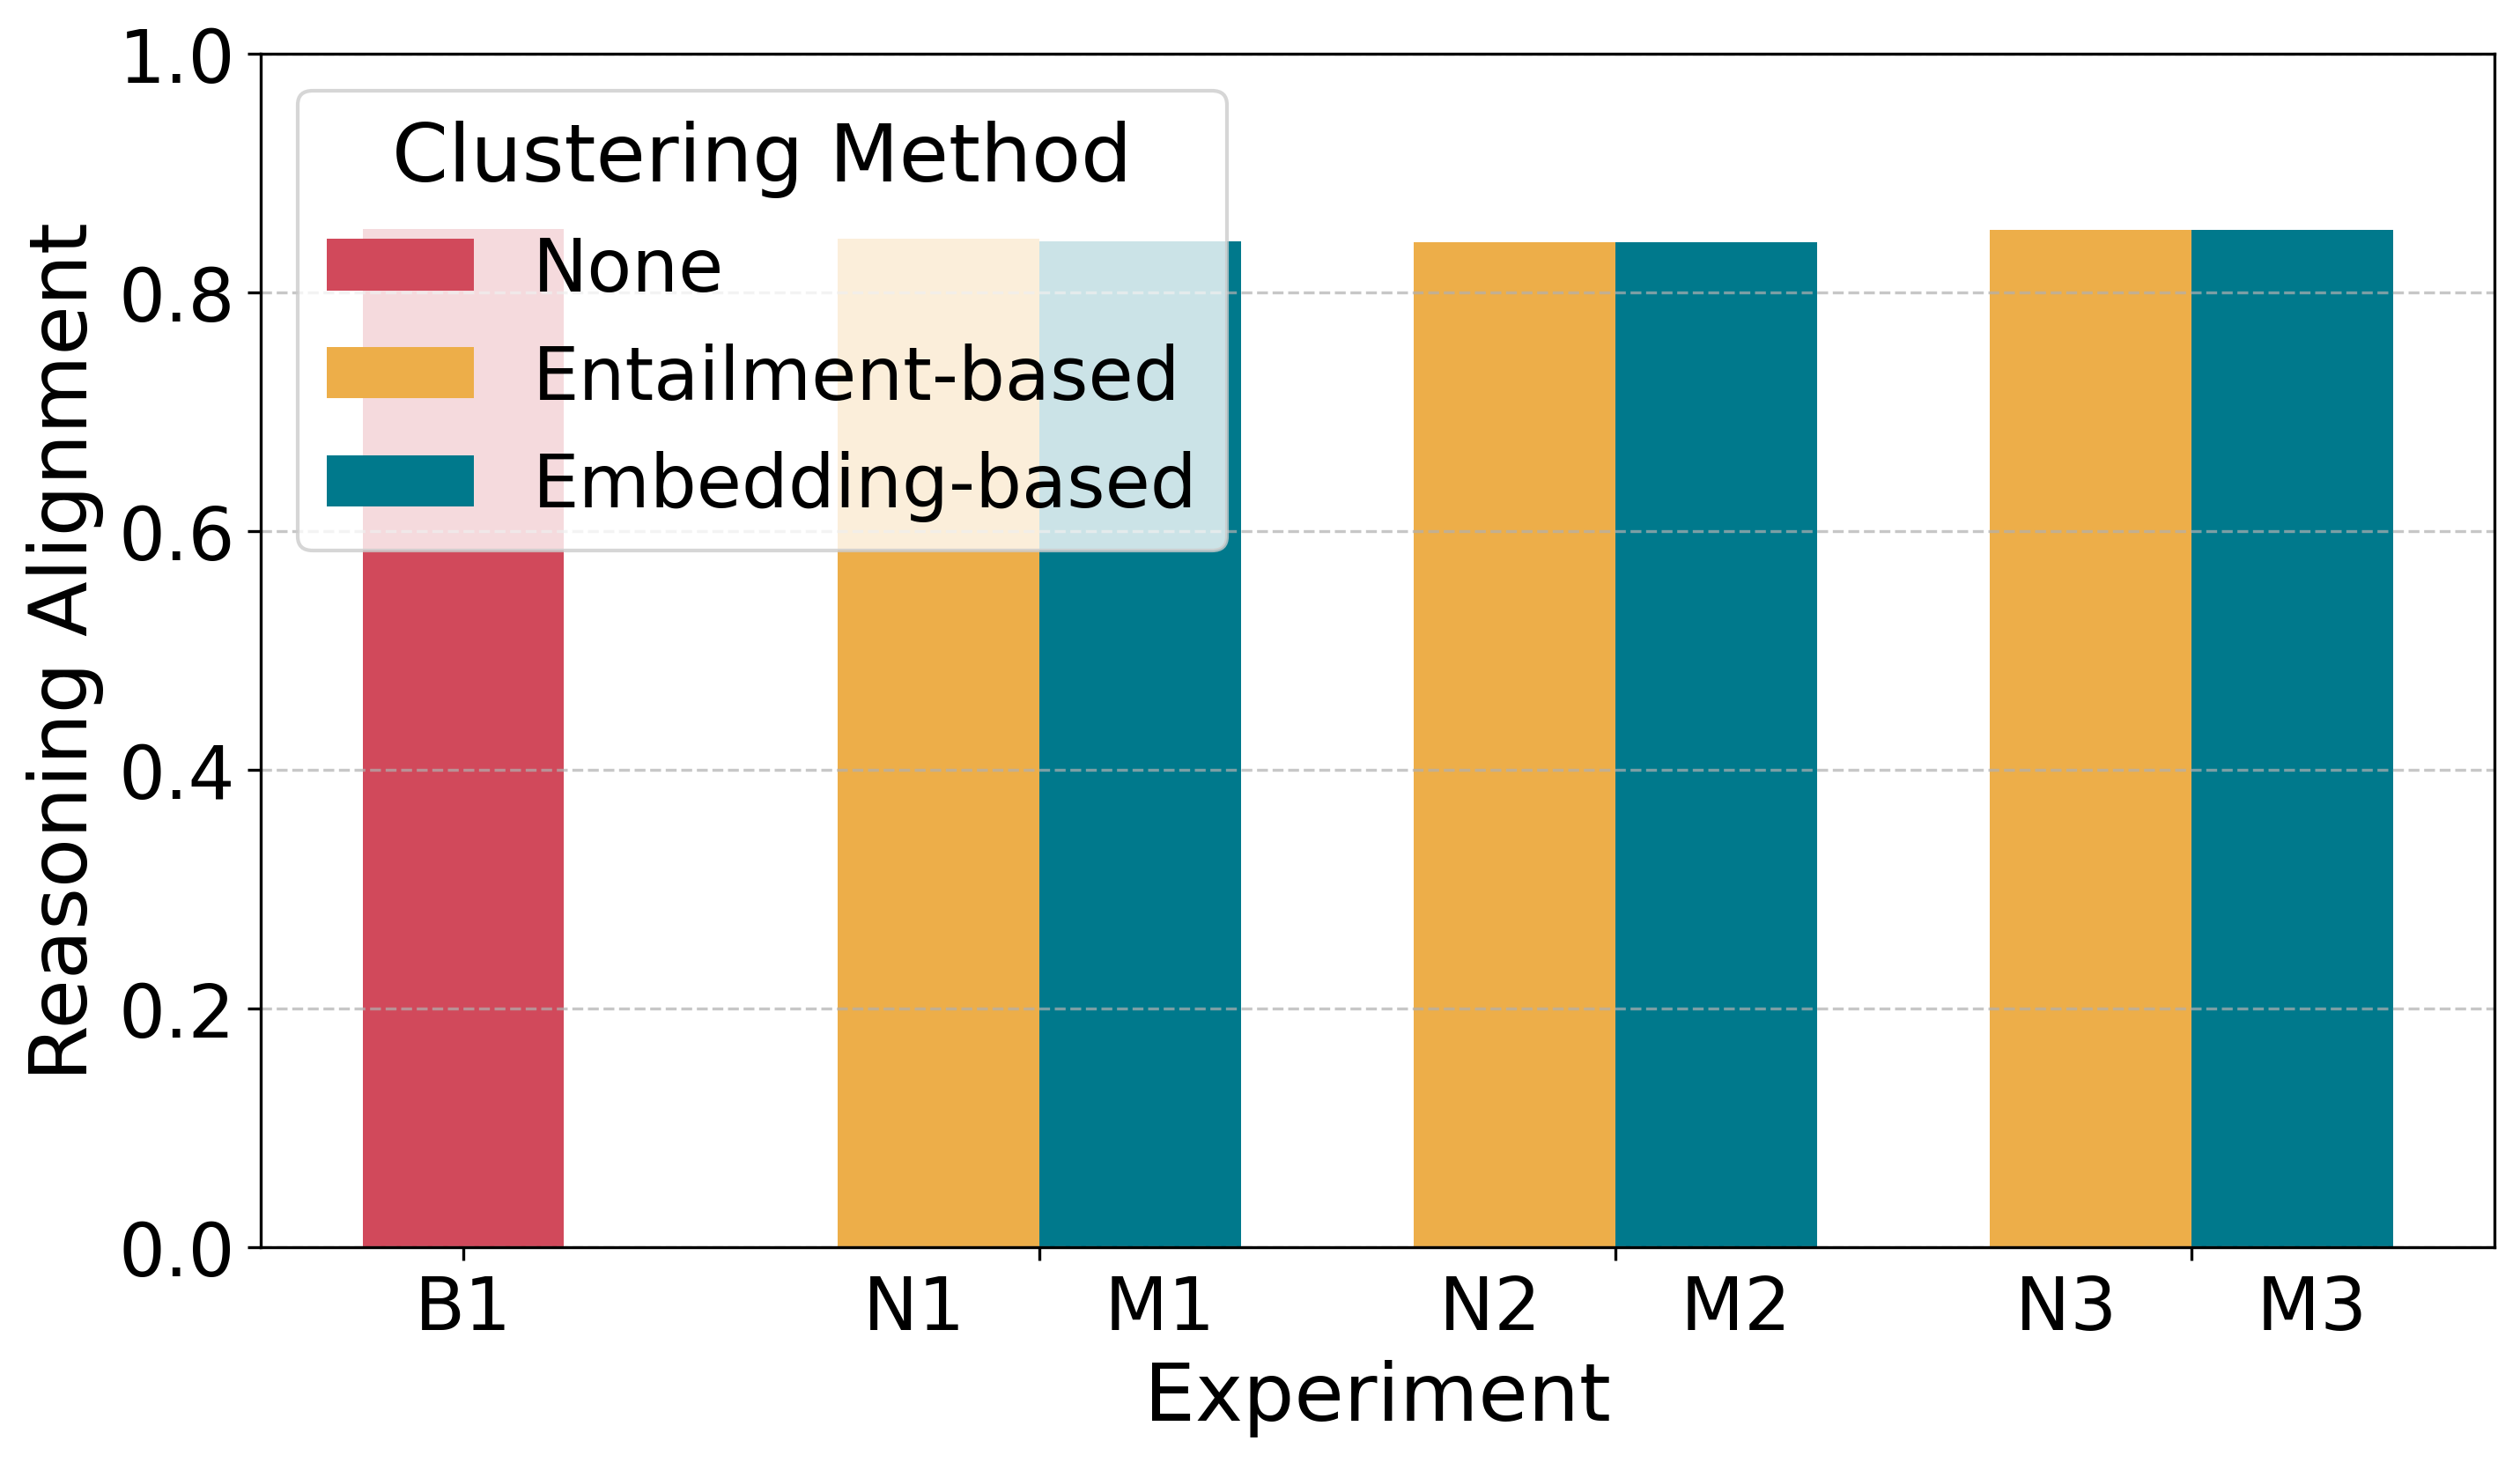

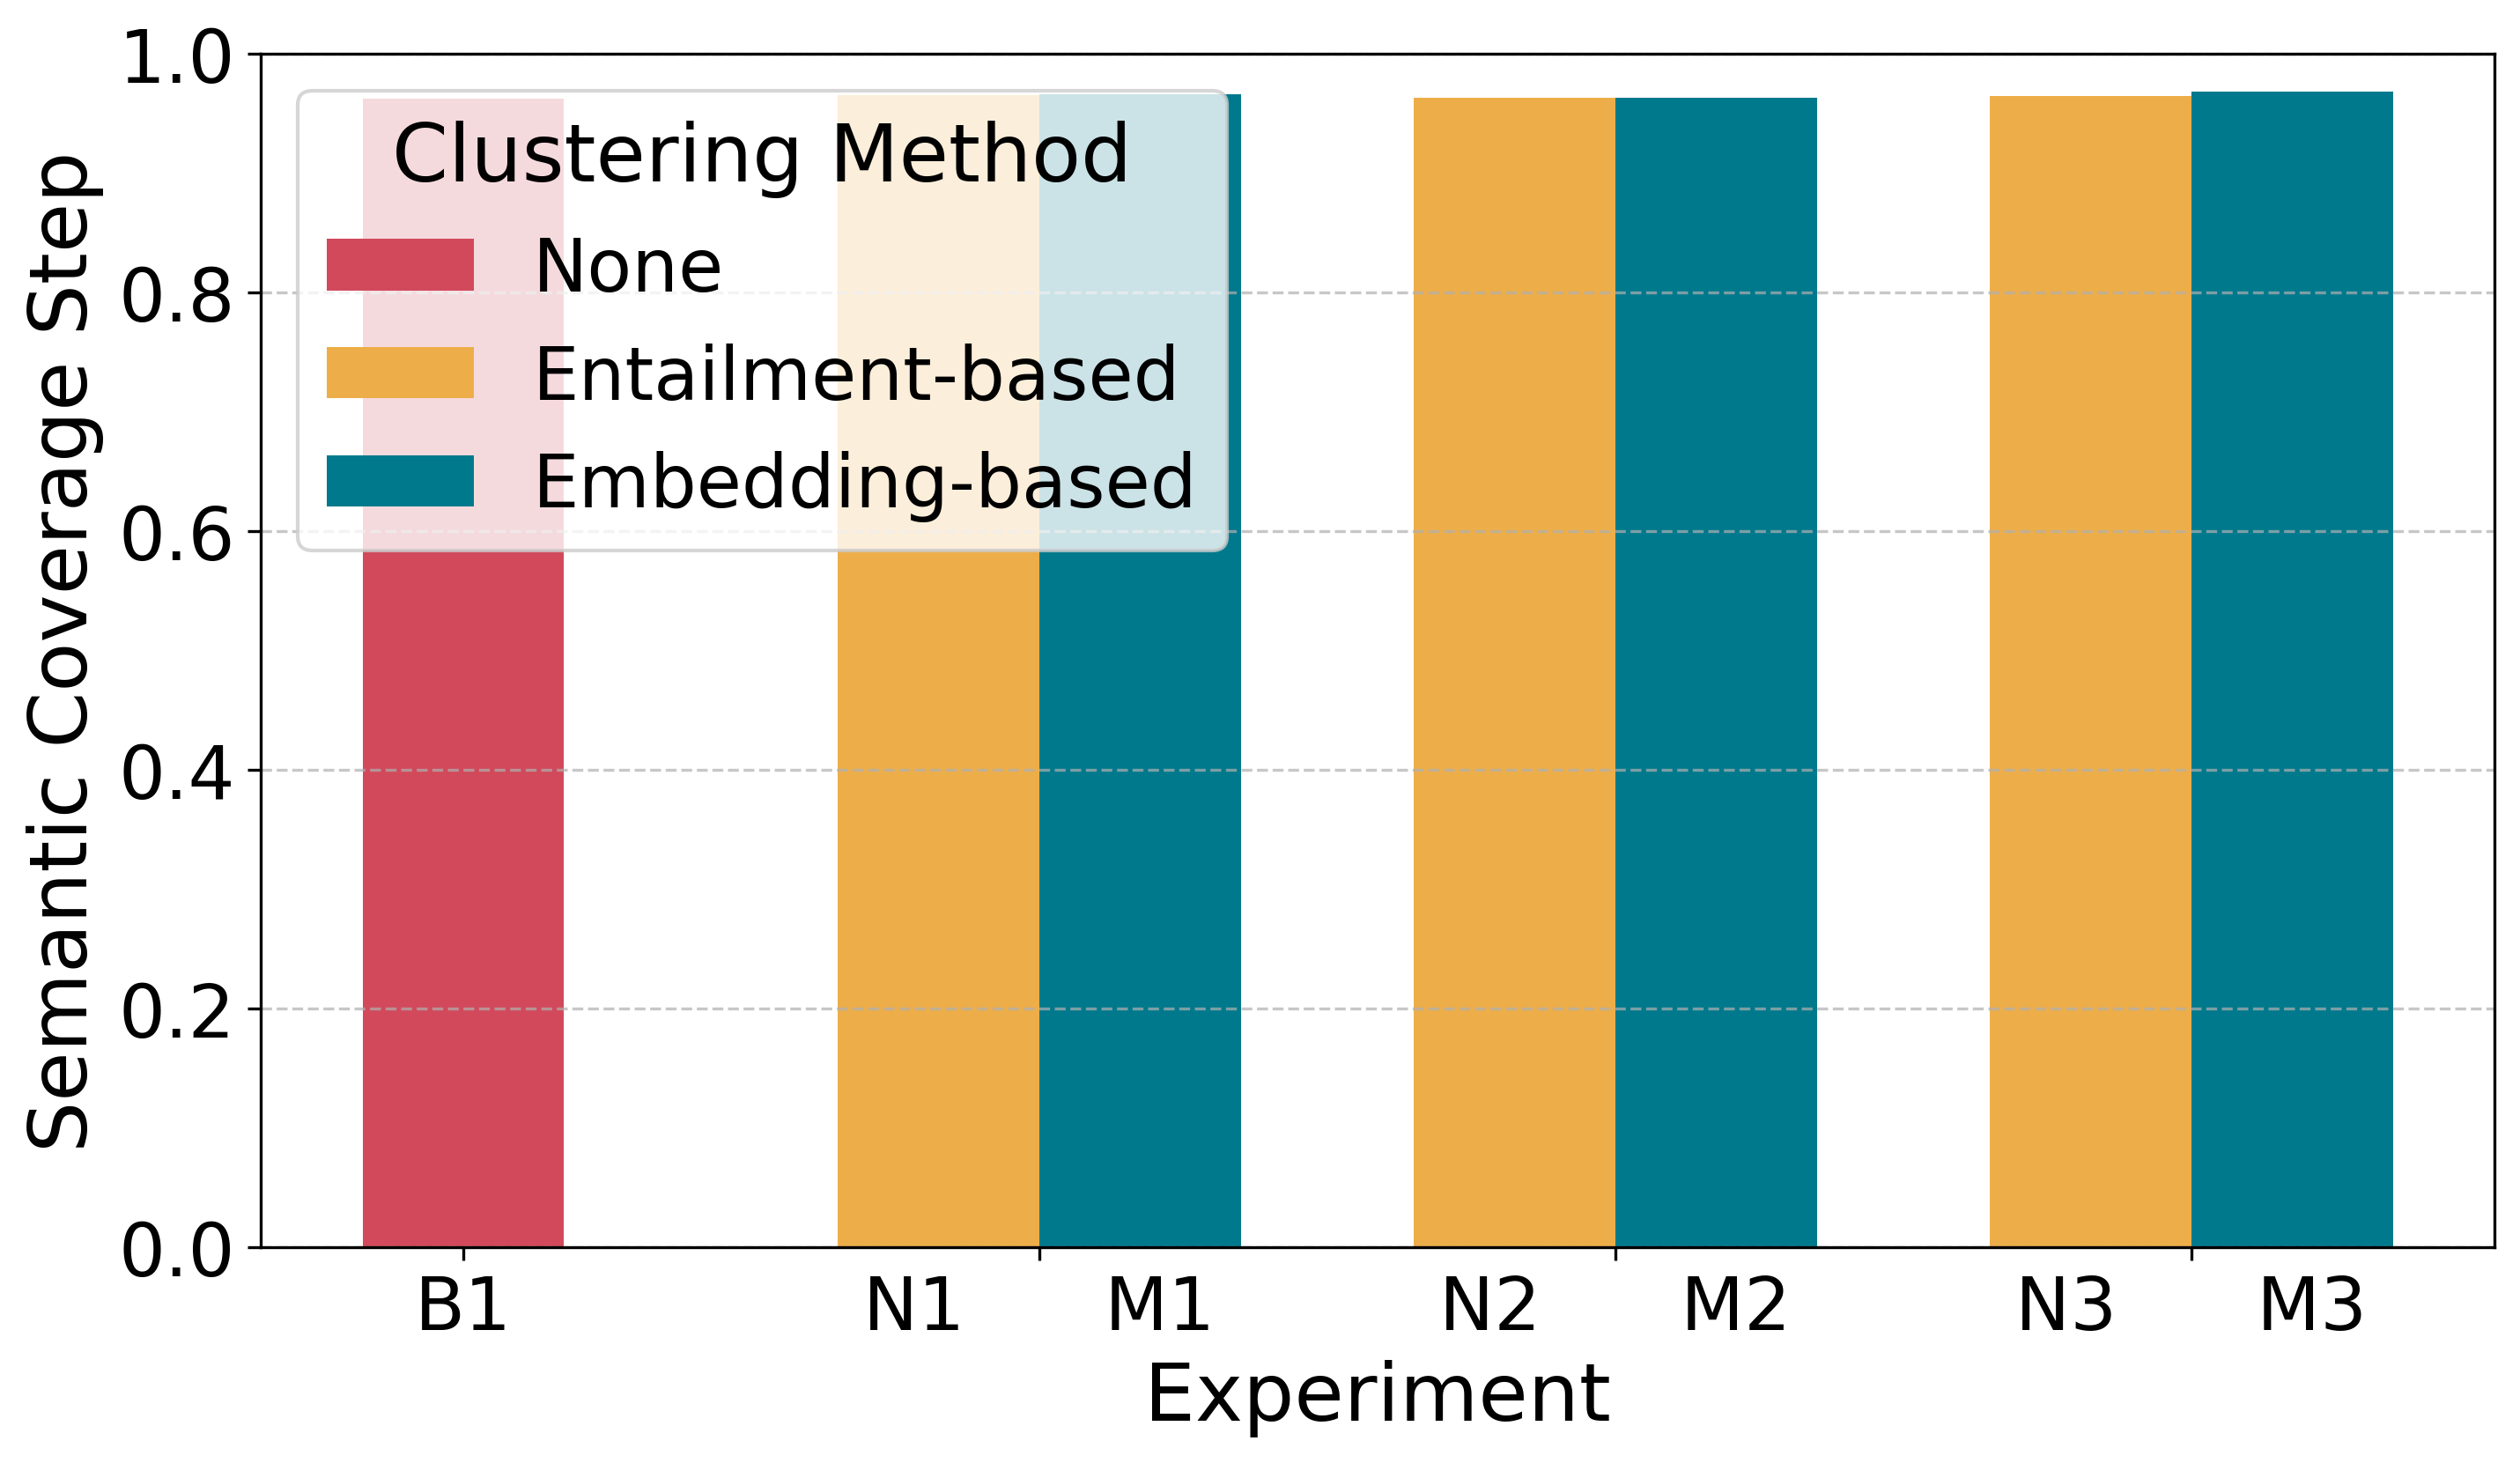

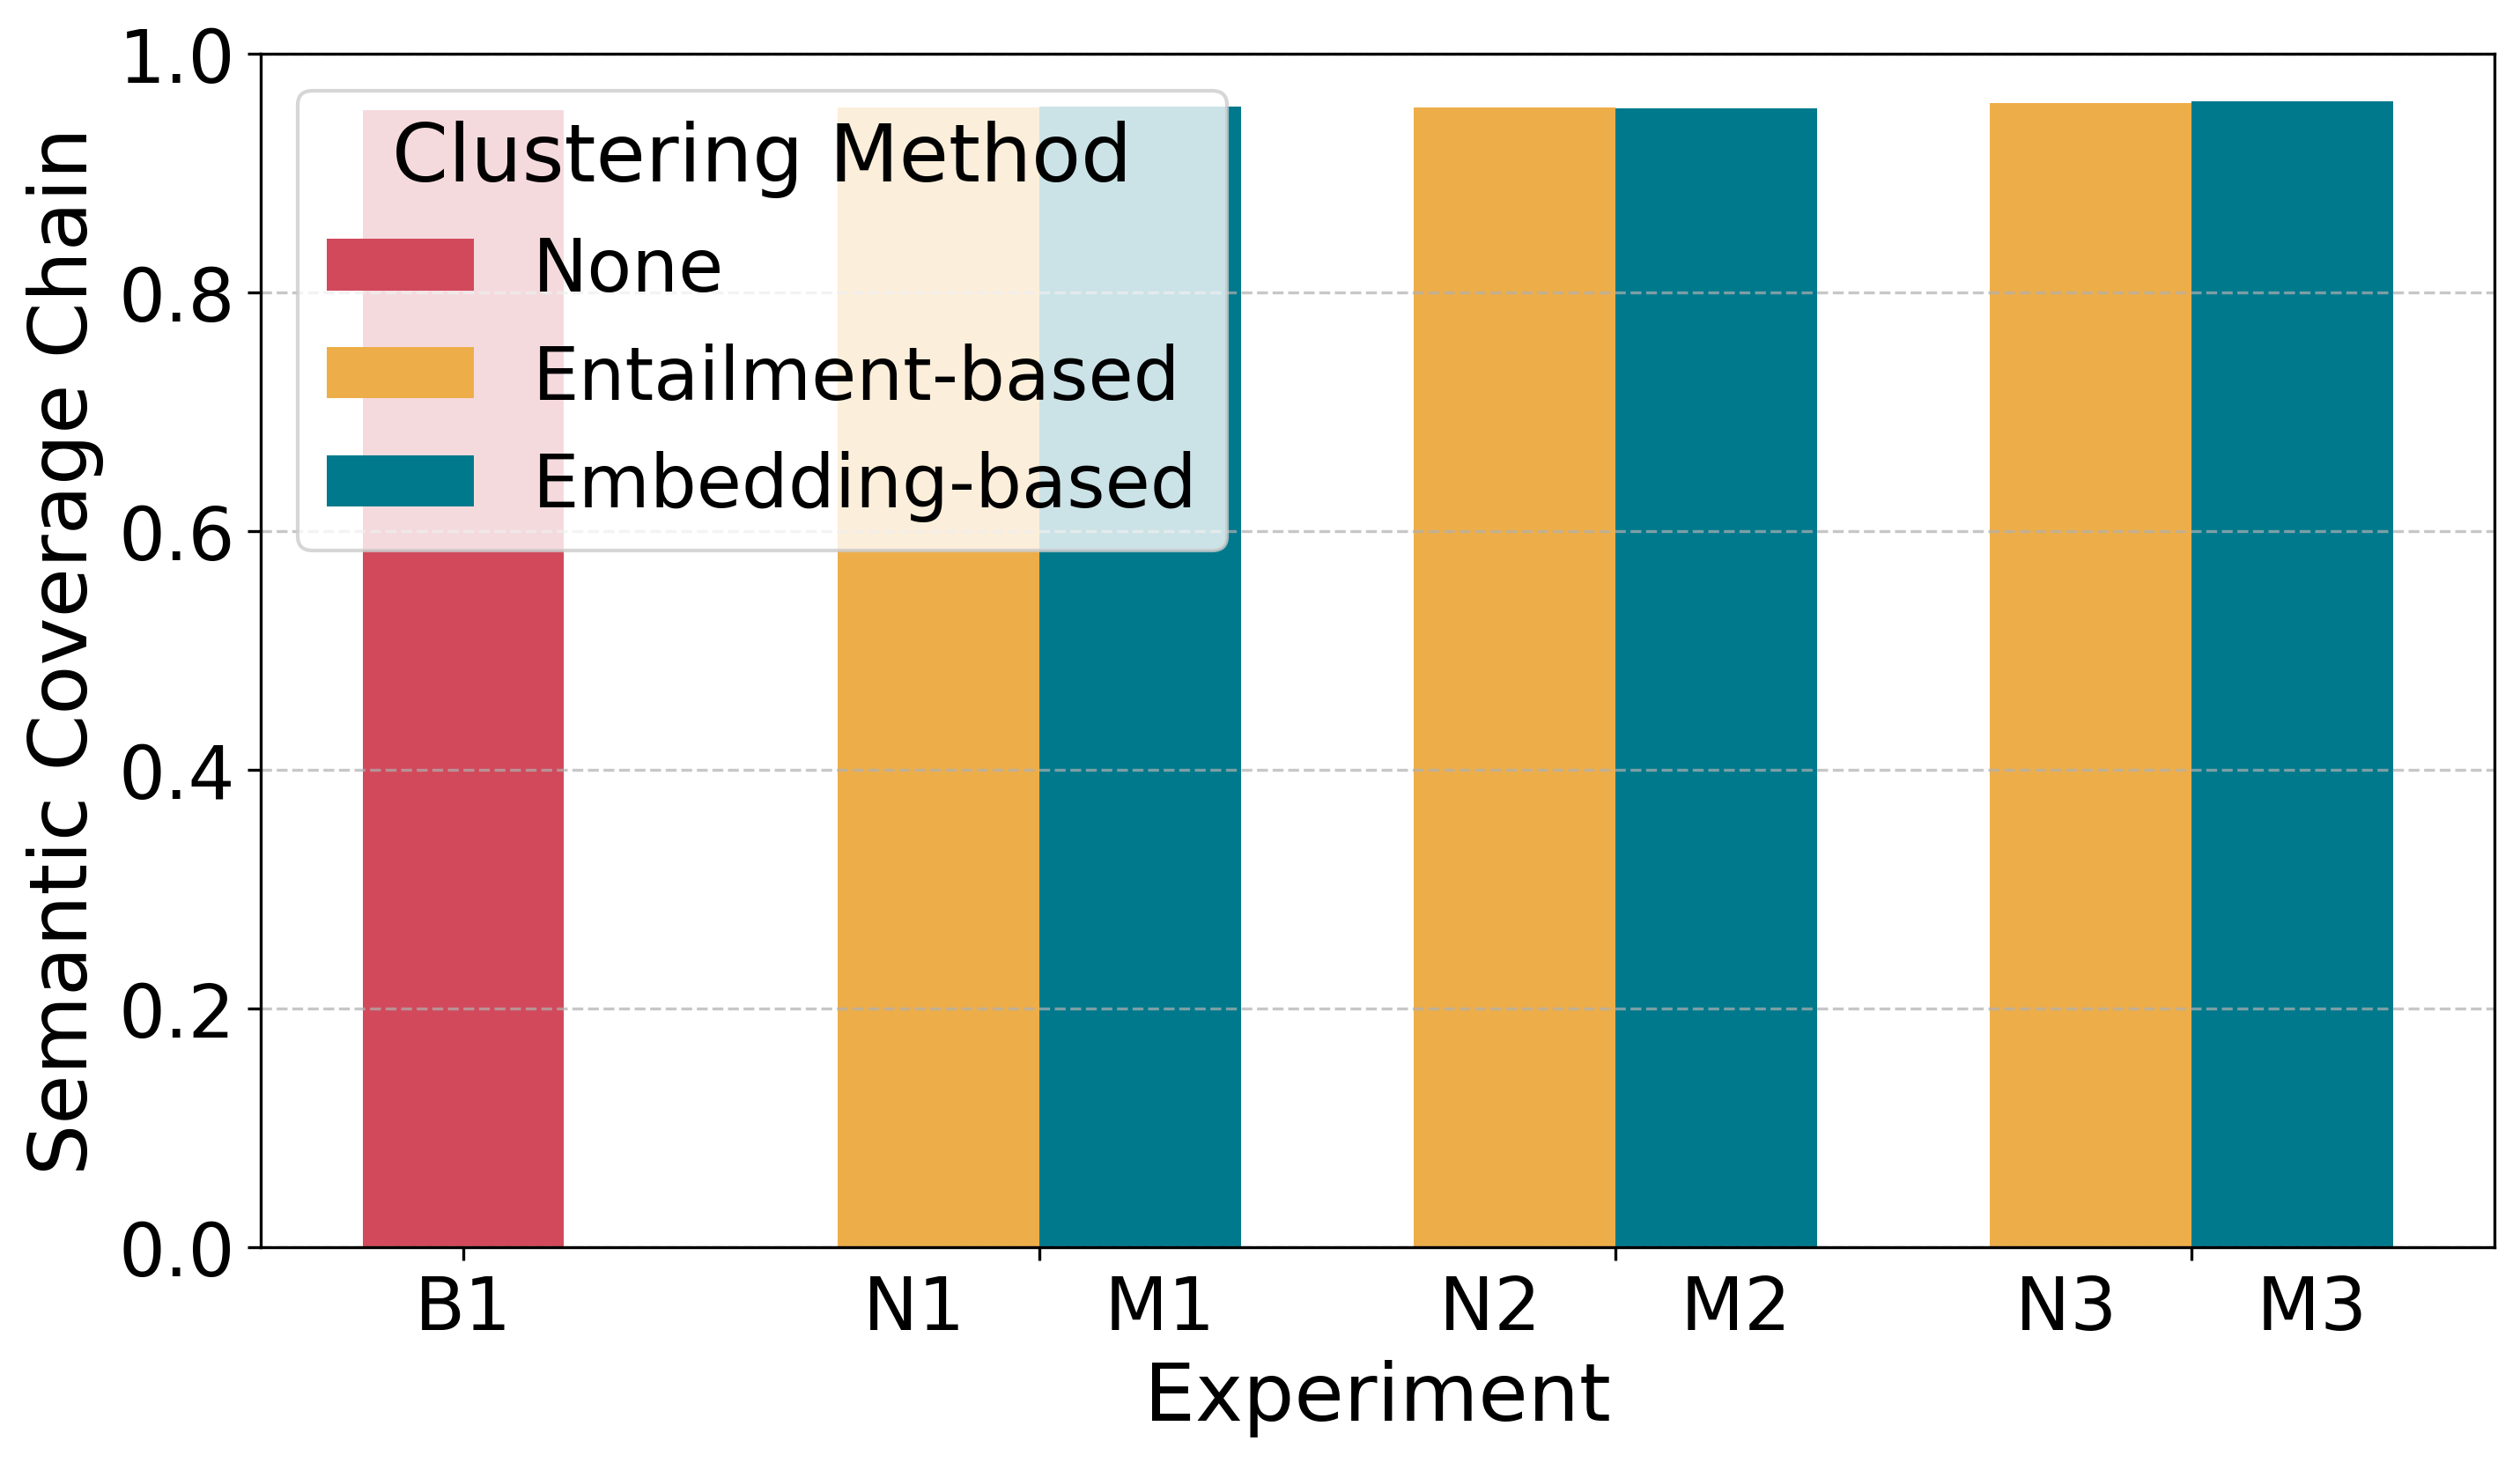

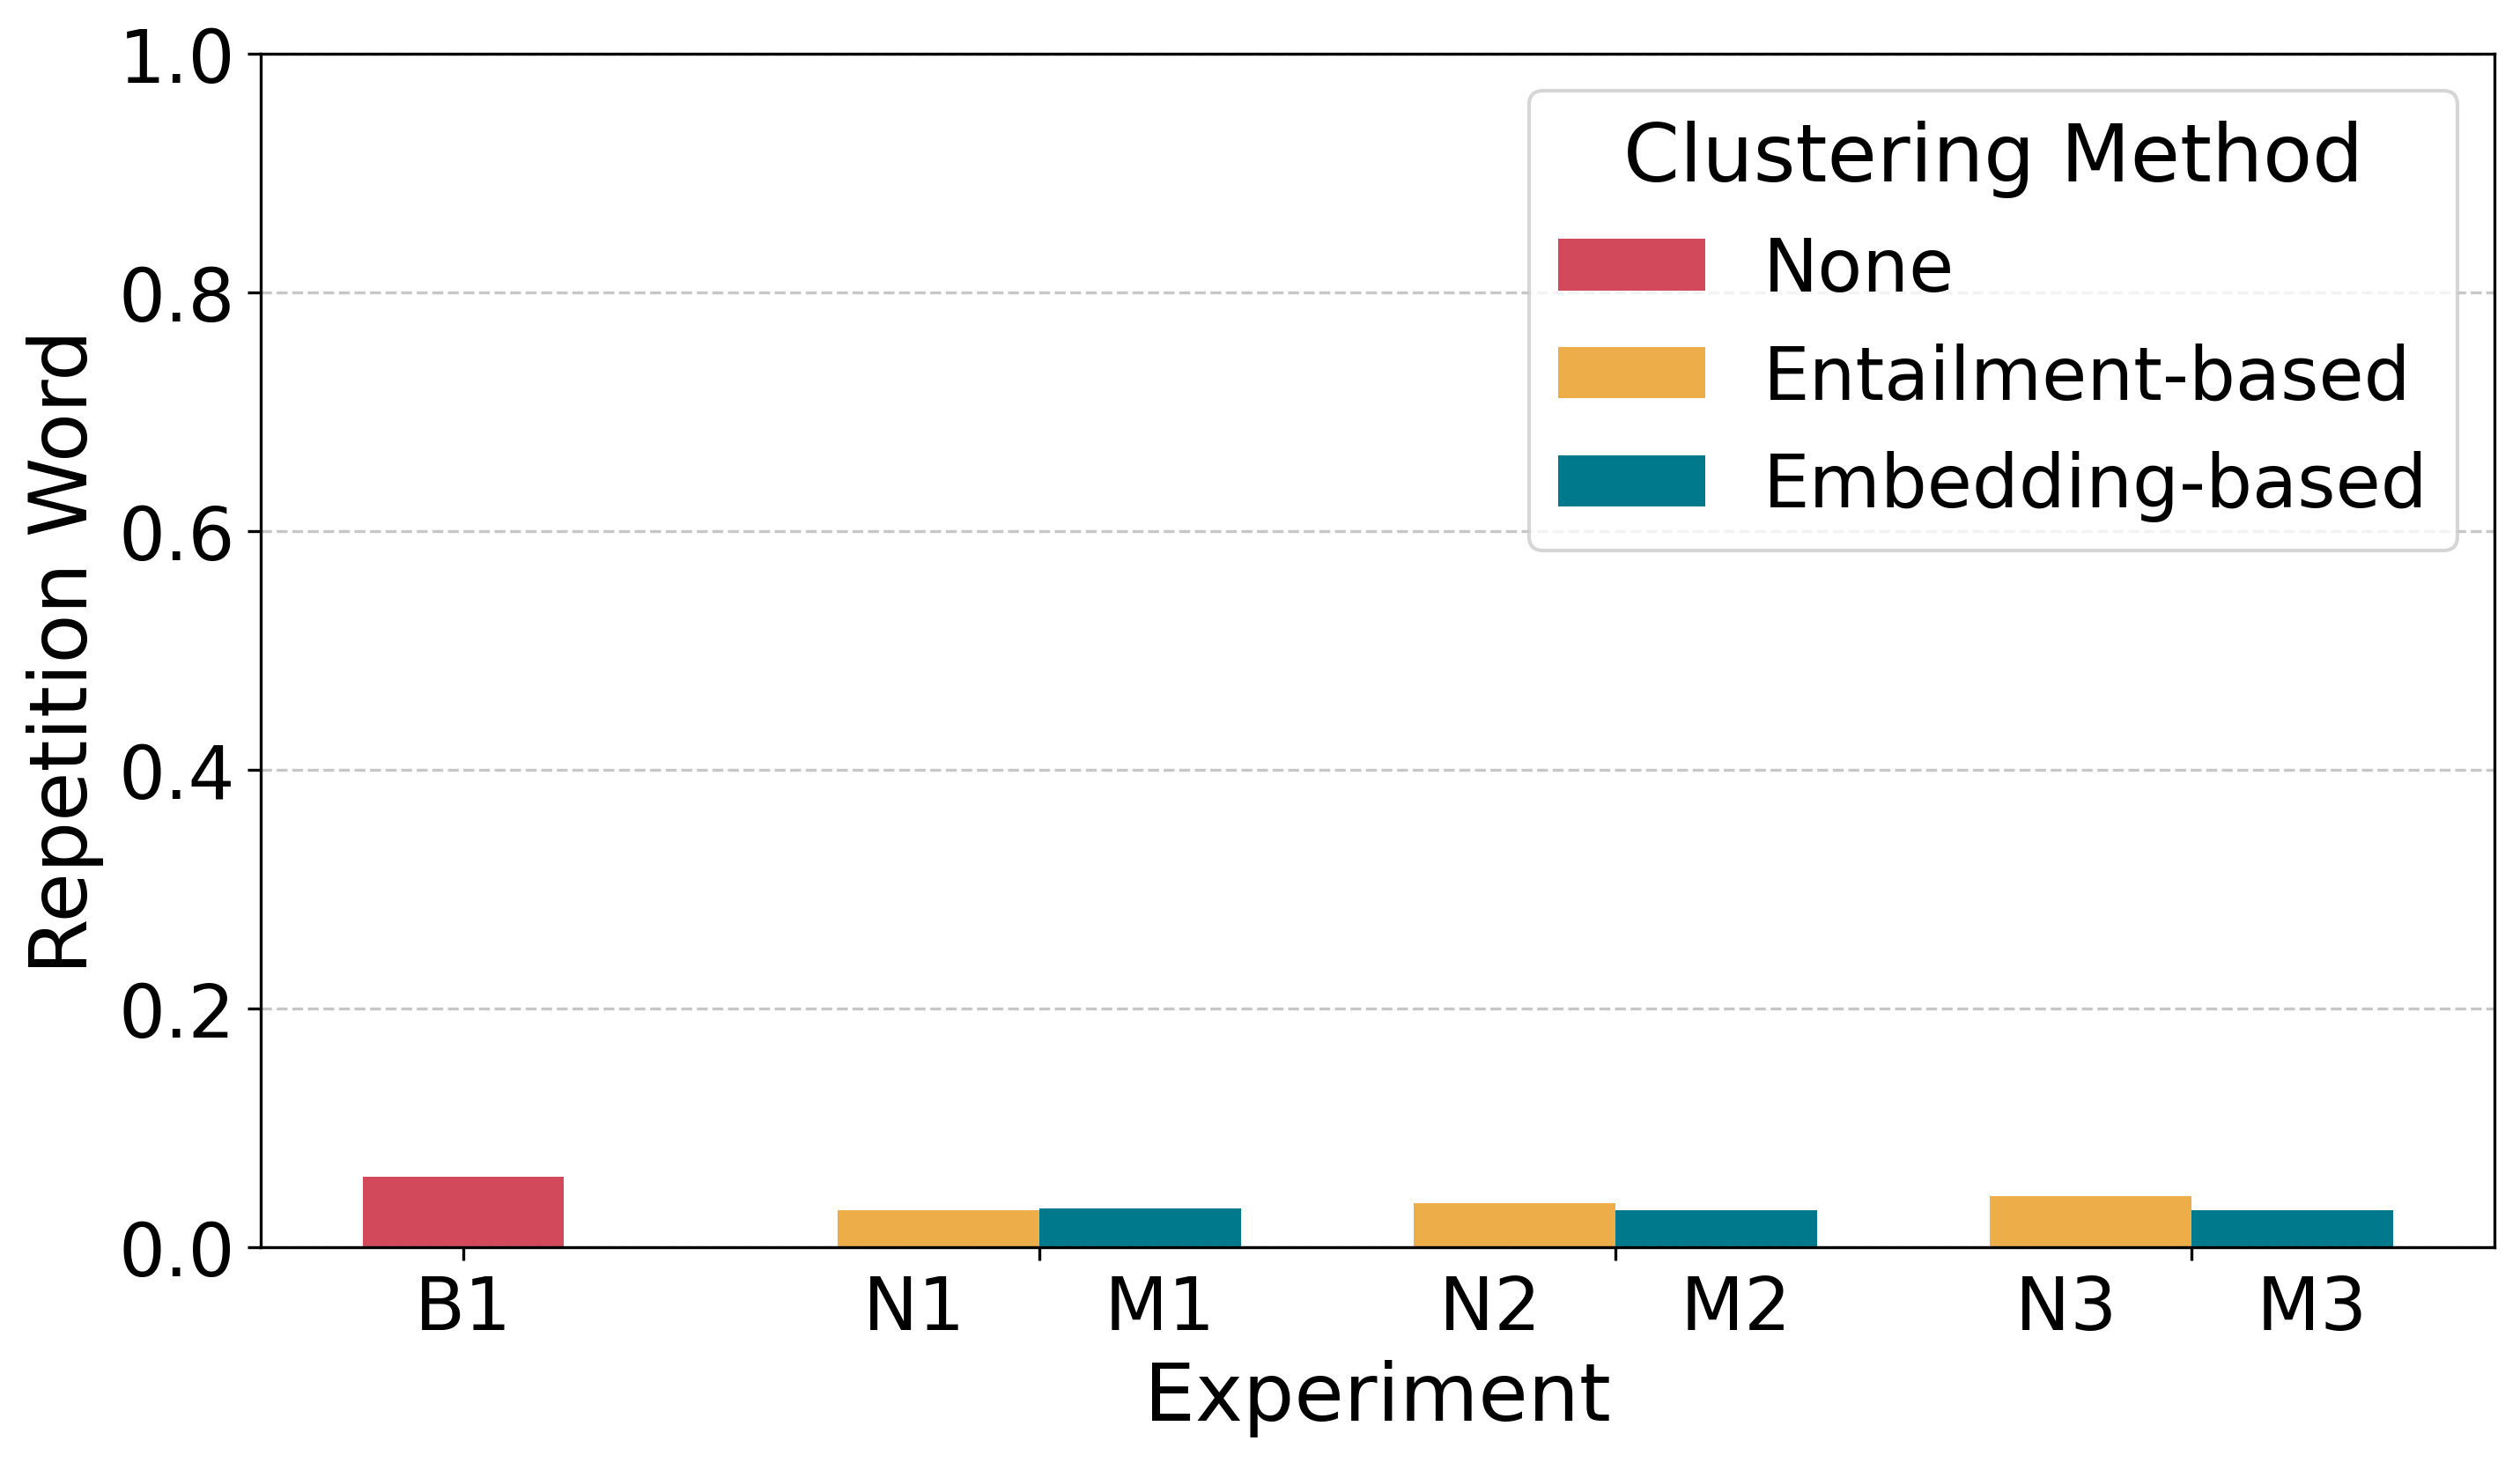

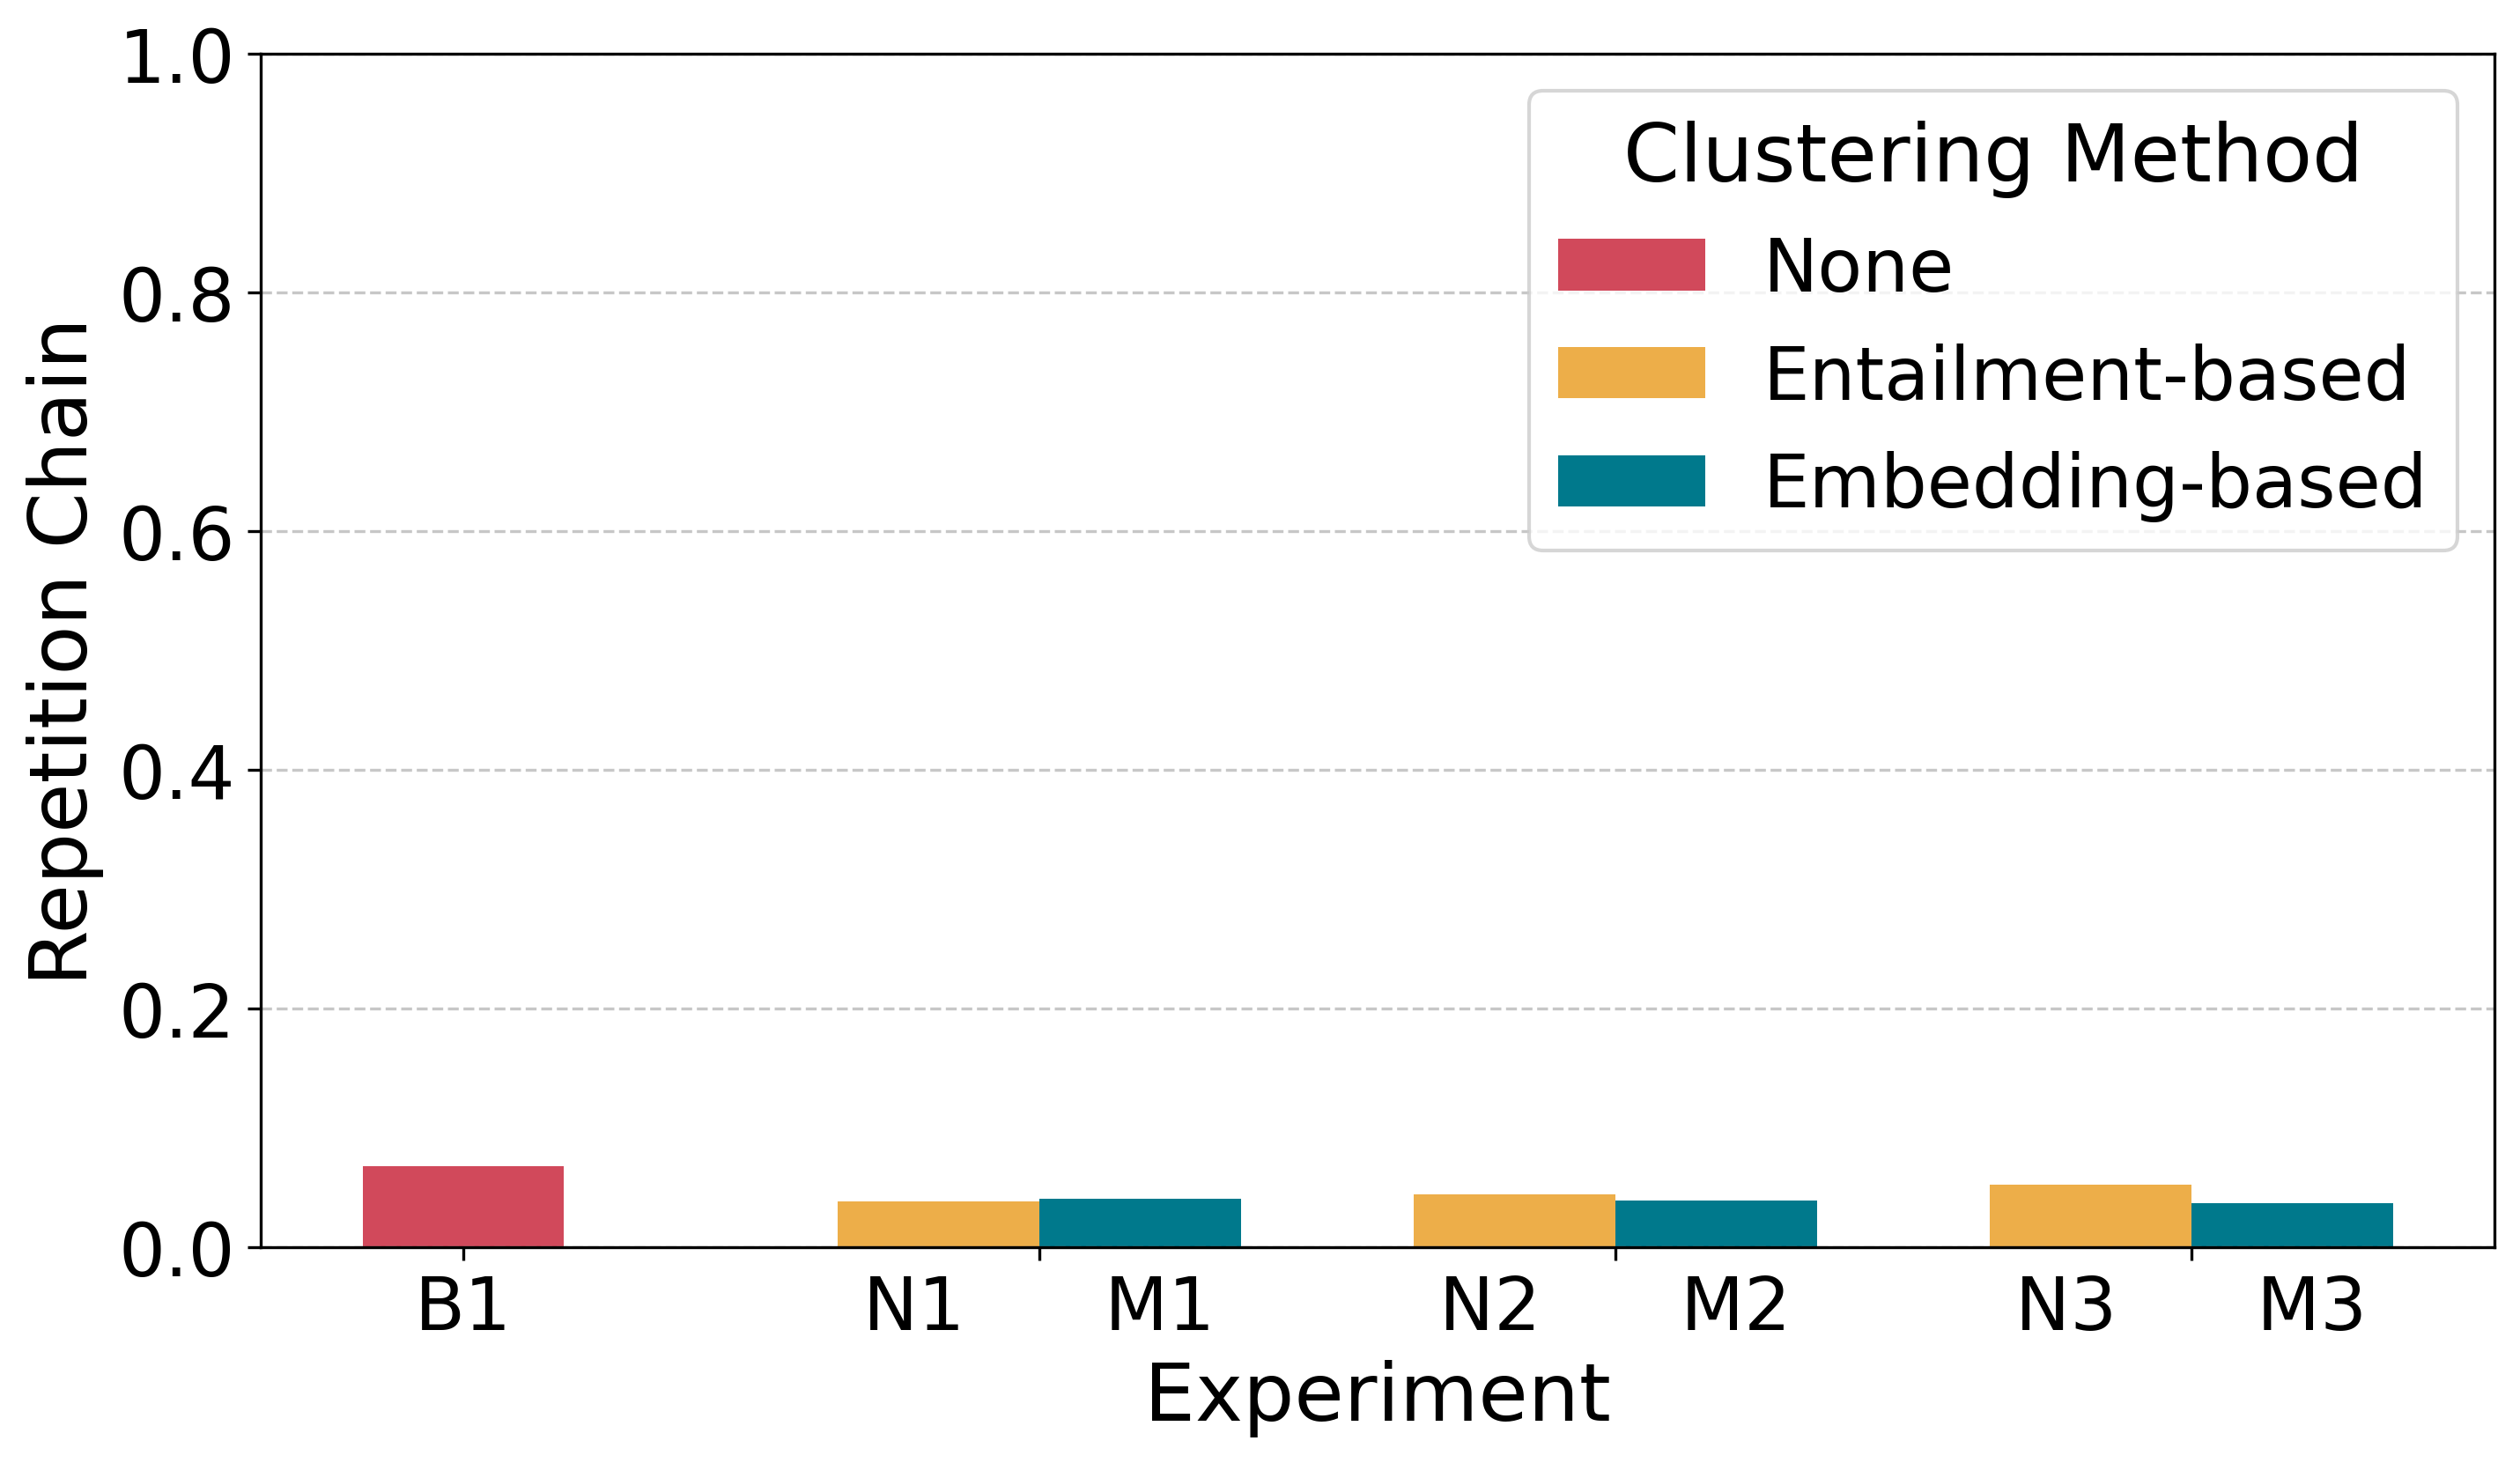

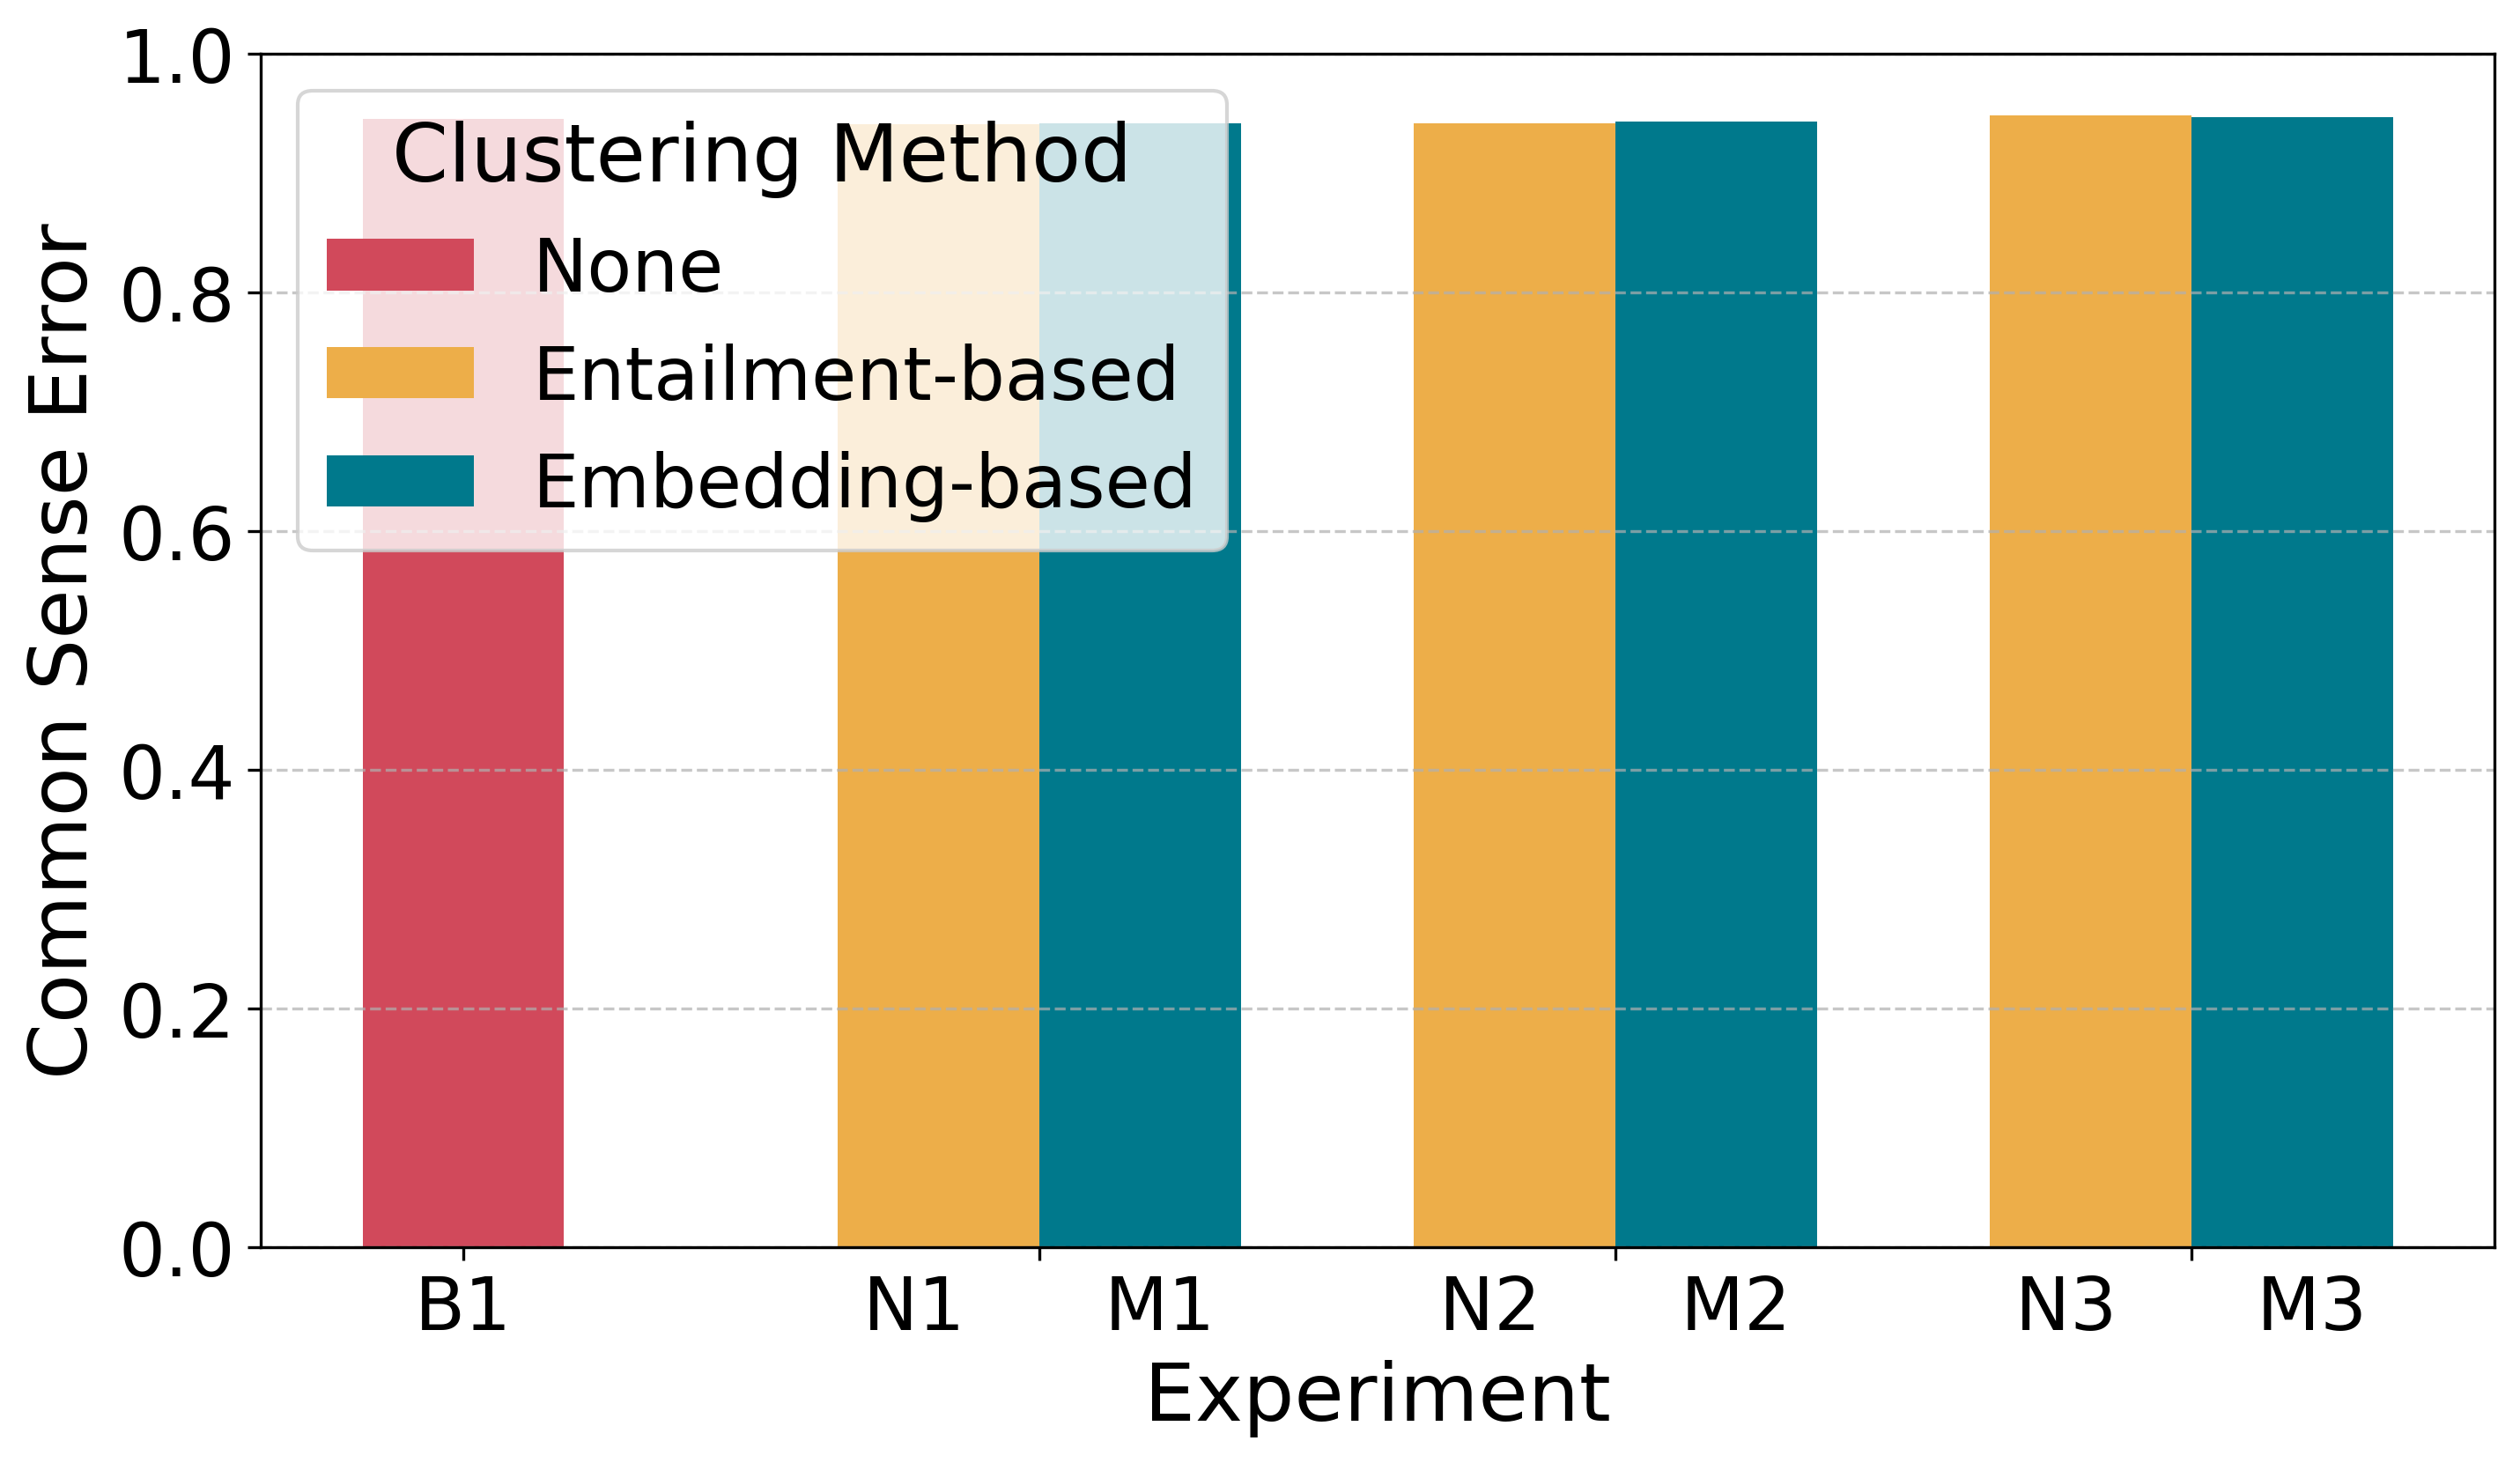

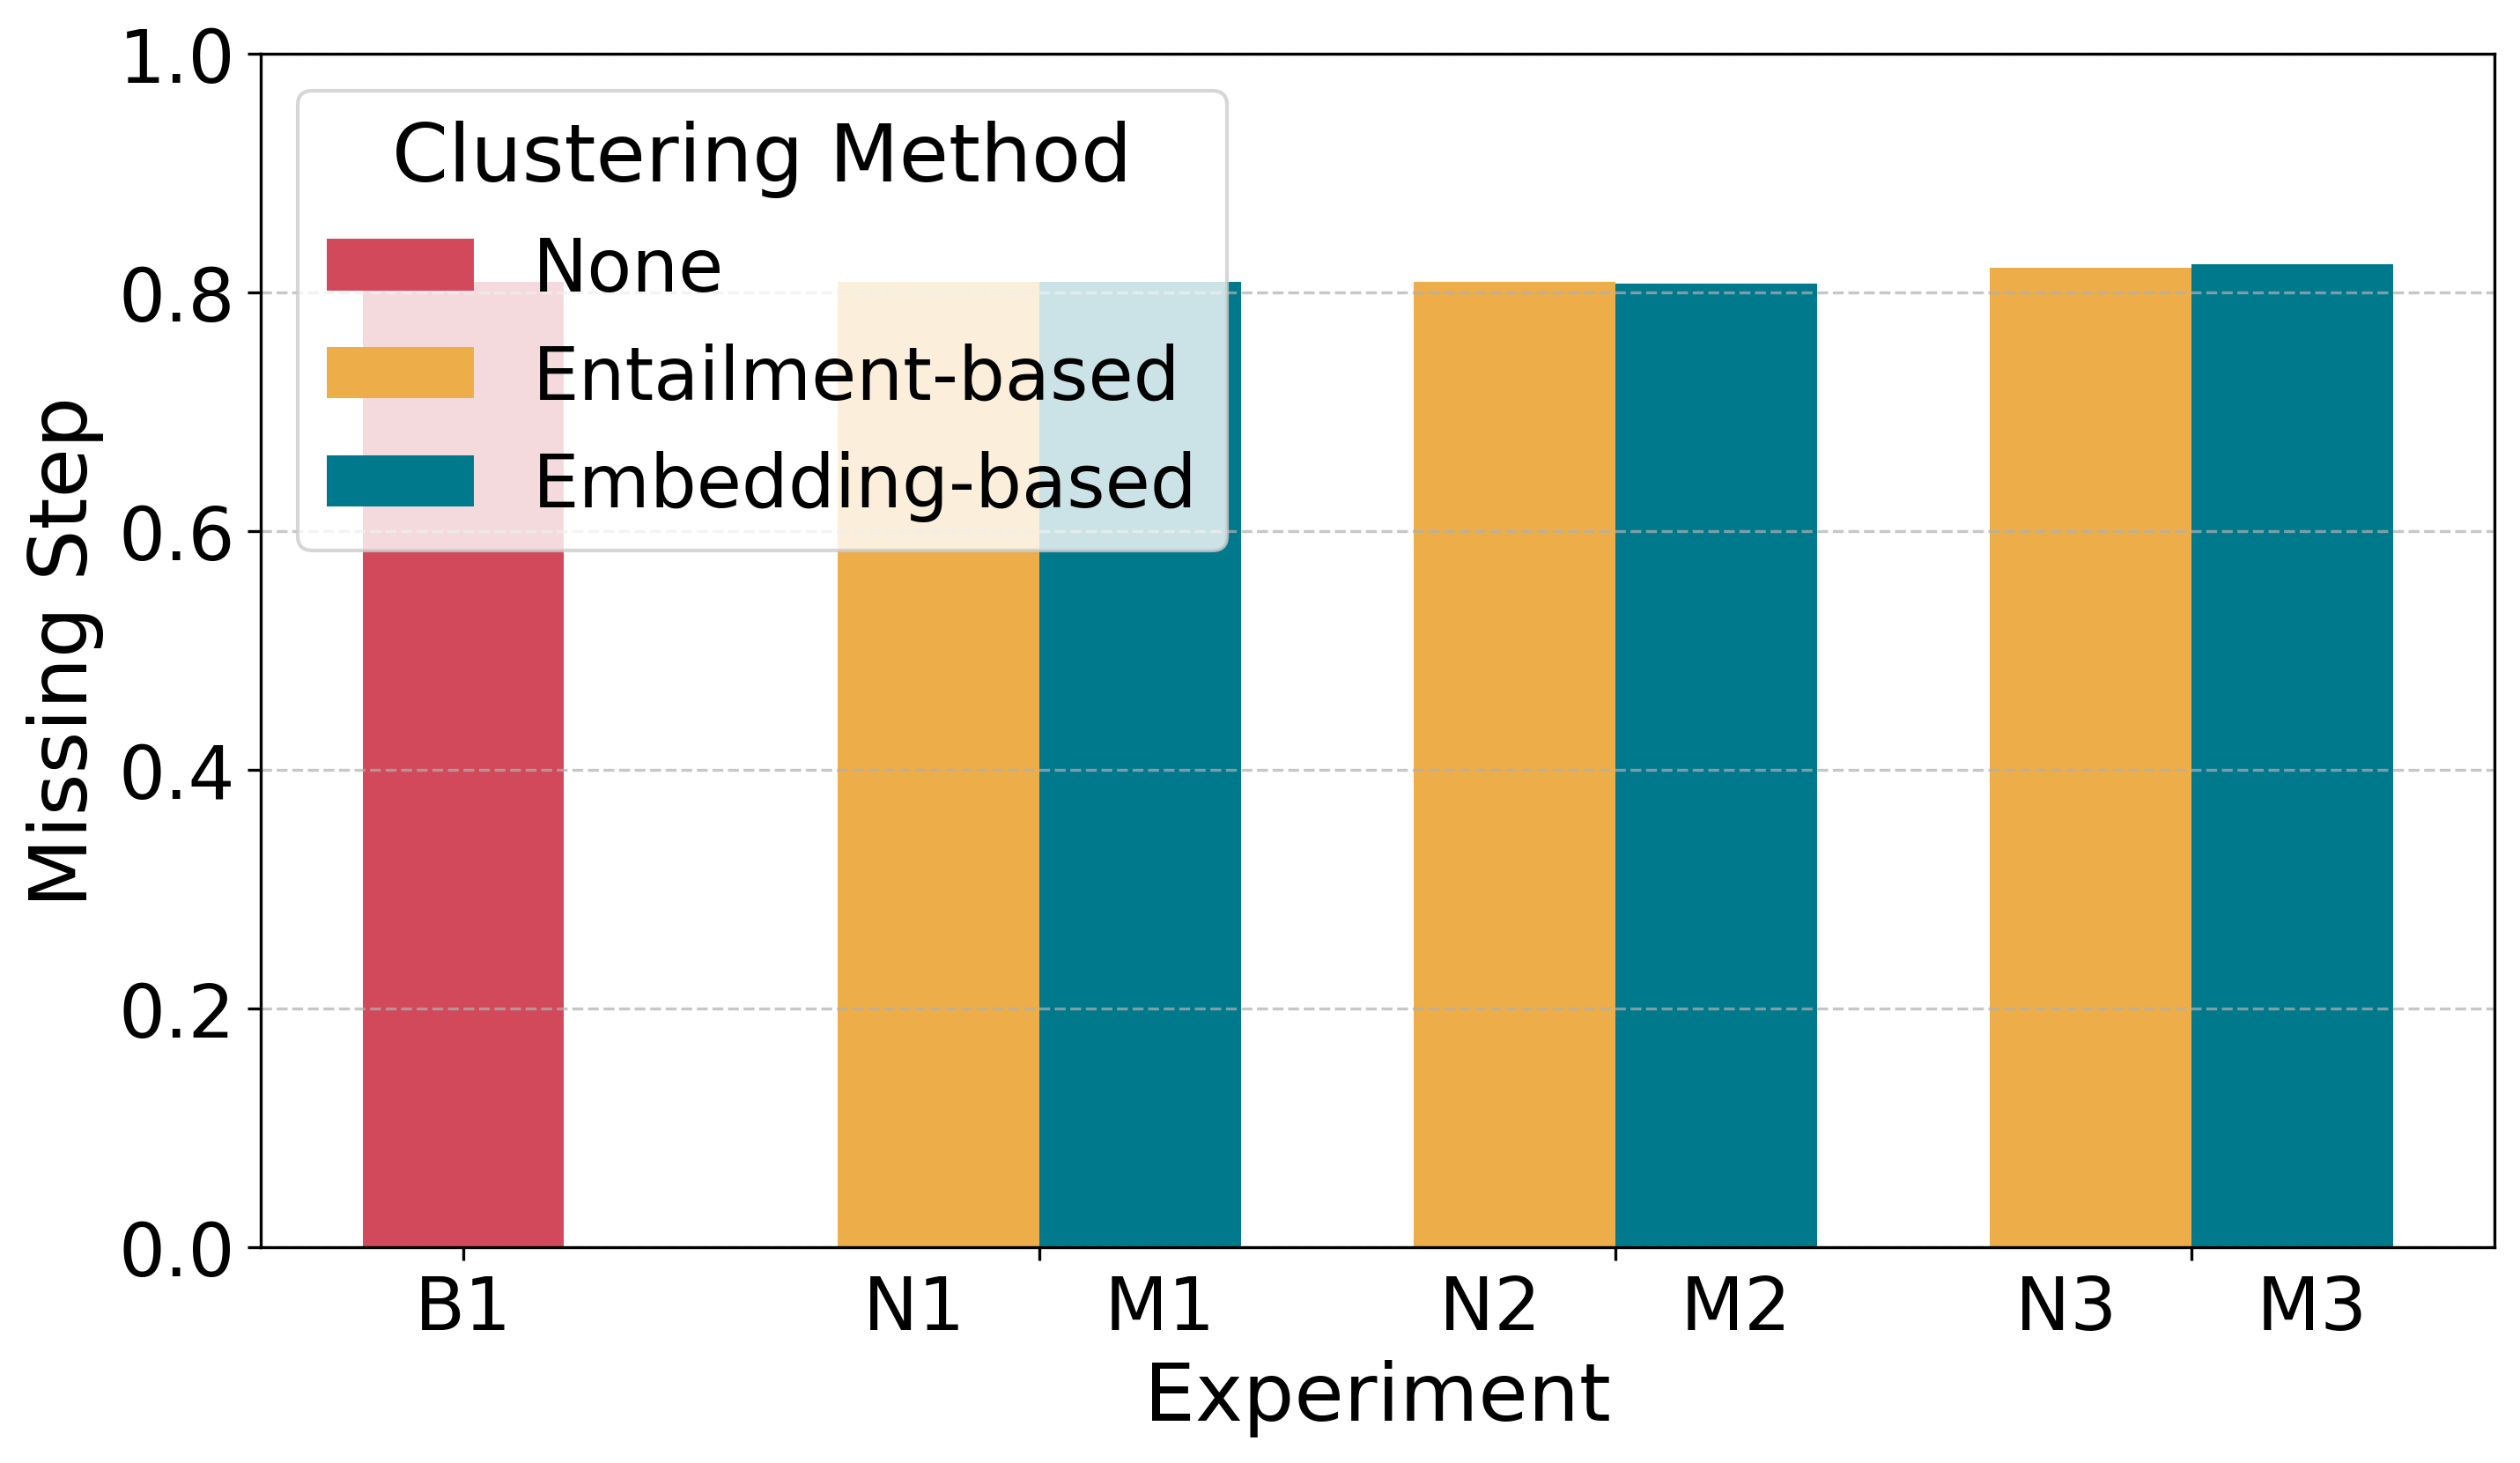

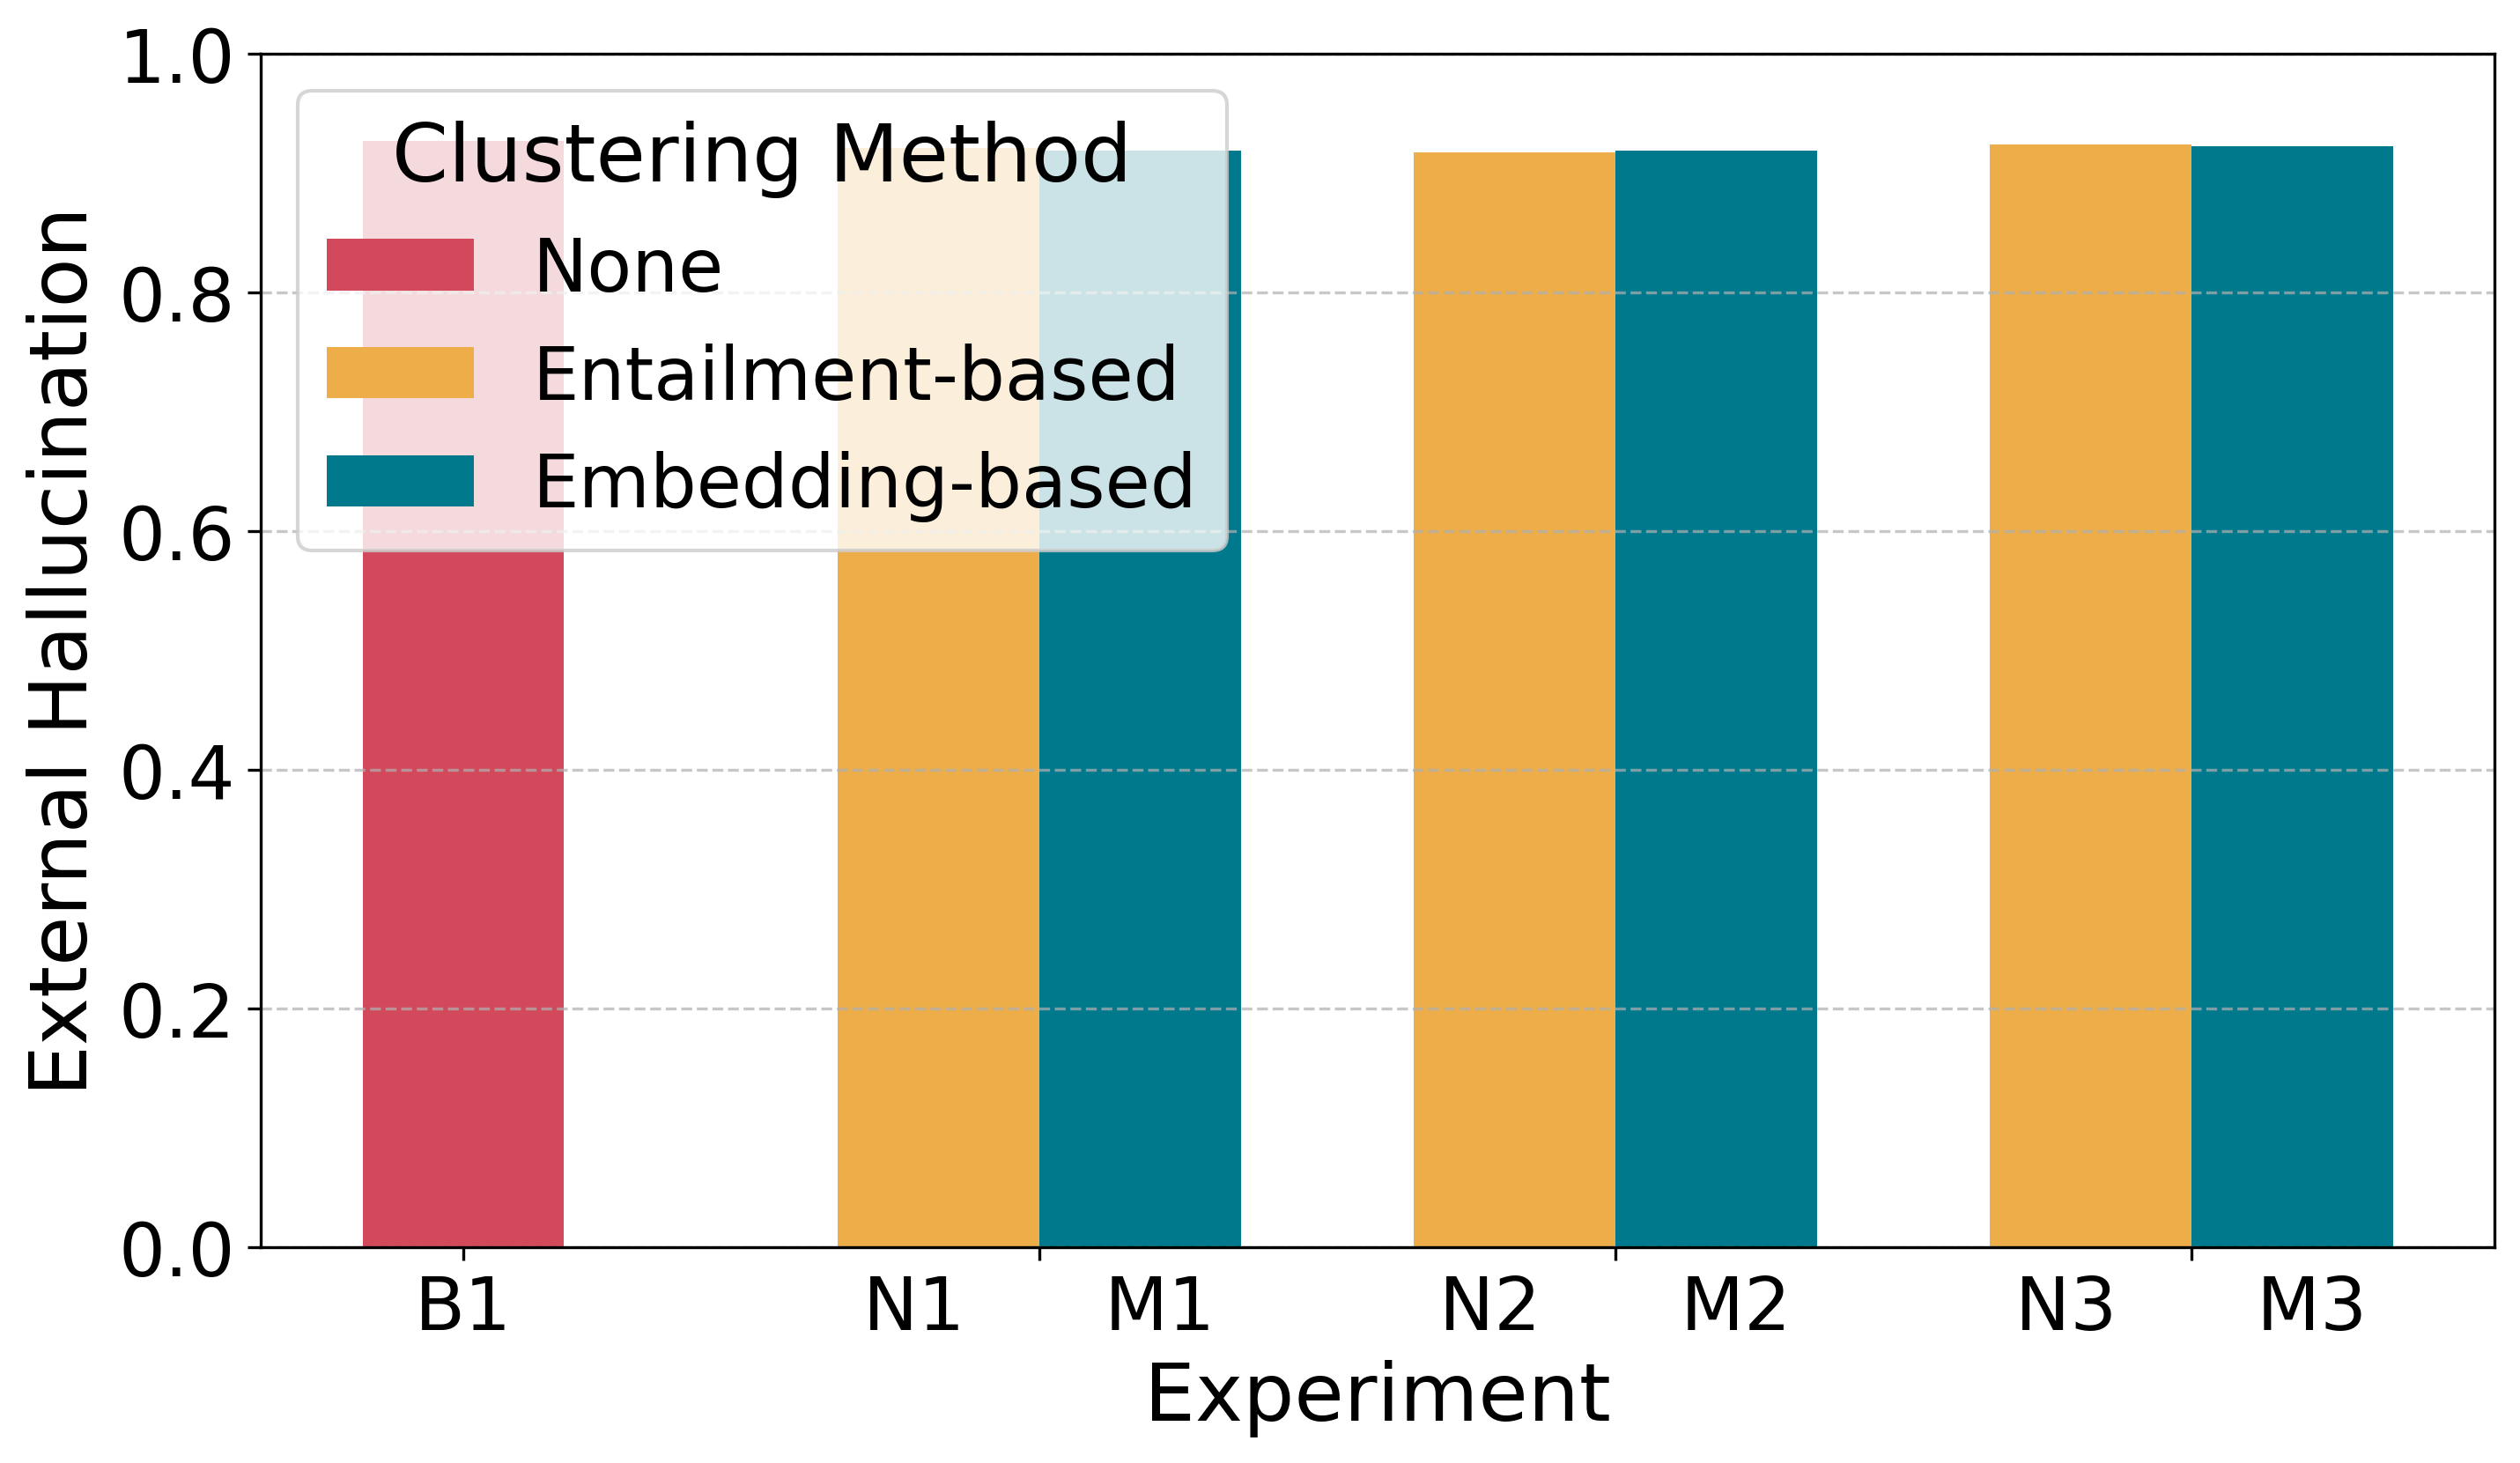

In [12]:
m = ["reasoning_alignment", "semantic_coverage_step", "semantic_coverage_chain", "repetition_word", "repetition_step", "common_sense_error", "missing_step", "external_hallucination"]
ylabels = ["Reasoning Alignment", "Semantic Coverage Step", "Semantic Coverage Chain", "Repetition Word", "Repetition Chain", "Common Sense Error", "Missing Step", "External Hallucination"]
title = [f"{i} per Experimental Configuration" for i in ylabels]

for i in range(len(m)):
    create_plot(metric_file_name=f"_roscoe_results.tsv", metric_column=m[i], ylabel=ylabels[i], title="")

## For the 4B model

In [19]:
groups = [
    ("B1", ["big_b1_2"]),
    ("N1      M1", ["big_n1_2", "big_m1_2"]),
    ("N2      M2", ["big_n2_2", "big_m2_2"]),
    ("N3      M3", ["big_n3_2", "big_m3_2"])
]
color_map = {
    "big_b1_2": "#d1495b",  # none
    "big_n1_2": "#edae49",  # entailment-based
    "big_n2_2": "#edae49",
    "big_n3_2": "#edae49",
    "big_m1_2": "#00798c",  # embedding-based
    "big_m2_2": "#00798c",
    "big_m3_2": "#00798c"
}

### Accuracy of the final answer

ERROR: ../experiments_results\big_n2_2\big_n2_2_em_results.jsonl not found. Defaulting to 100% accuracy.


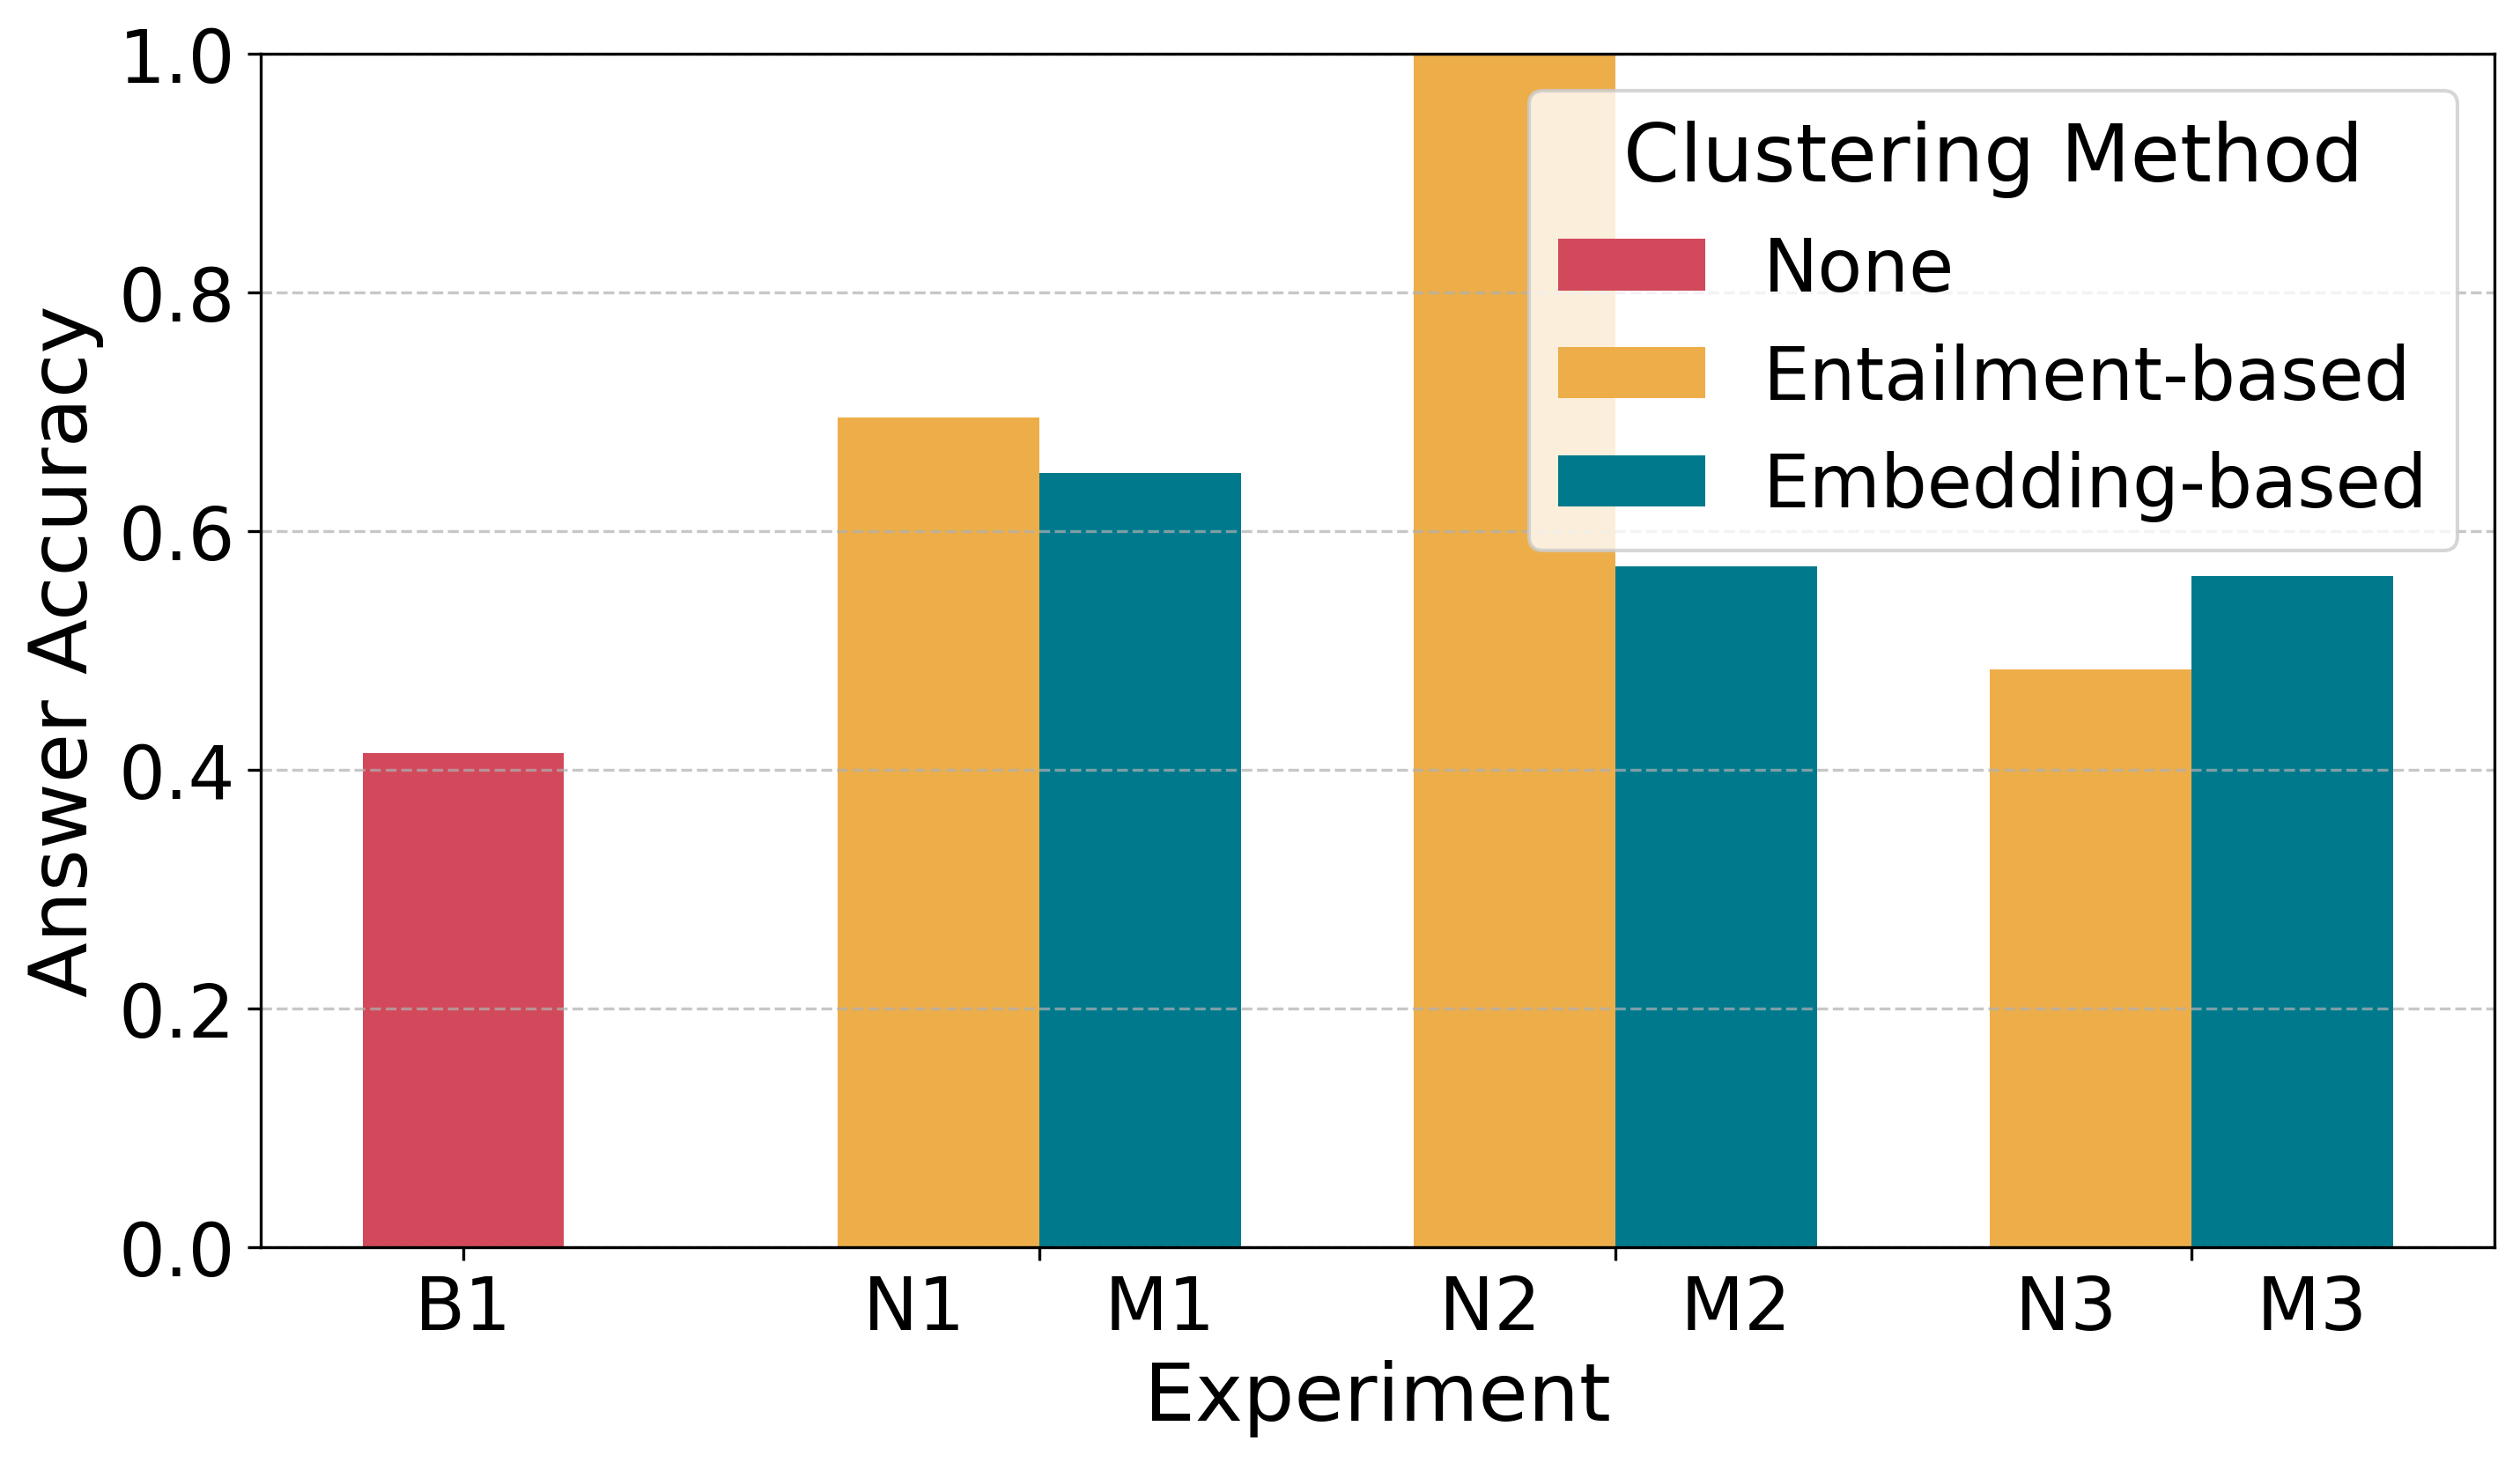

In [20]:
create_plot(metric_file_name="_em_results.jsonl", ylabel="Answer Accuracy", title="")

## Visualizations for report

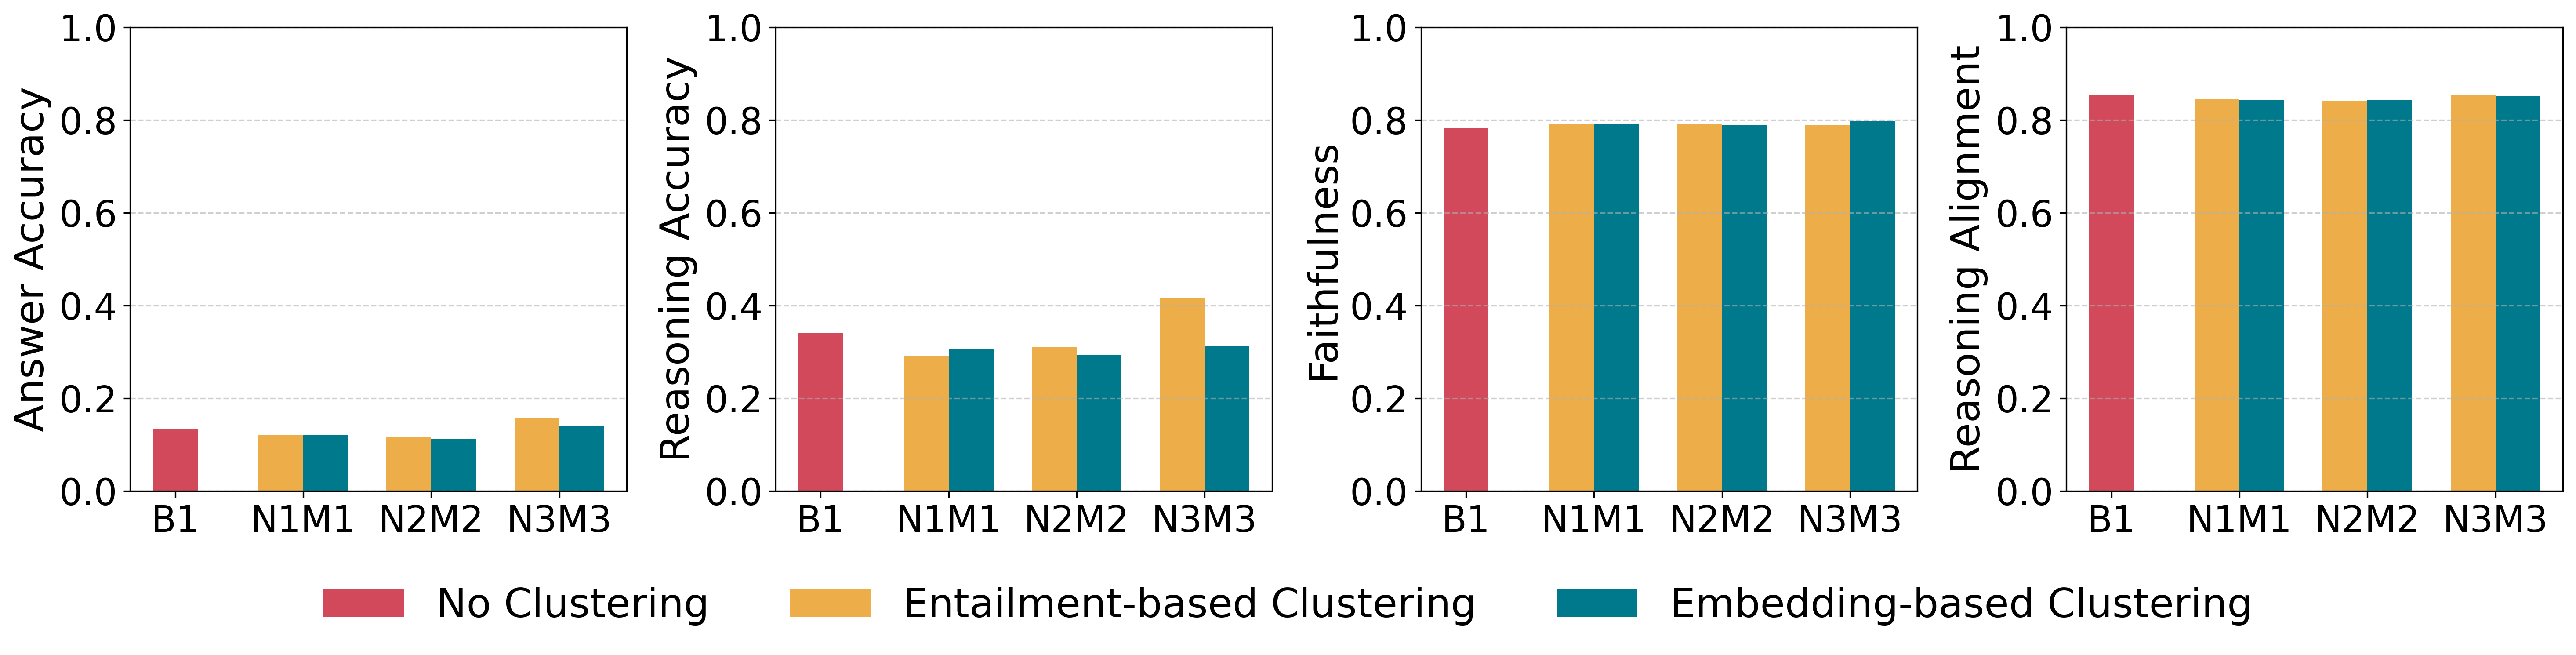

In [13]:
groups = [
    ("B1", ["b1_2"]),
    ("N1M1", ["n1_2", "m1_2"]),
    ("N2M2", ["n2_2", "m2_2"]),
    ("N3M3", ["n3_2", "m3_2"])
]

color_map = {
    "b1_2": "#d1495b",  # none
    "n1_2": "#edae49",  # entailment-based
    "n2_2": "#edae49",
    "n3_2": "#edae49",
    "m1_2": "#00798c",  # embedding-based
    "m2_2": "#00798c",
    "m3_2": "#00798c"
}

def create_1x4_plot_row(metric_configs):
    fig, axes = plt.subplots(1, len(metric_configs), figsize=(5*len(metric_configs), 5))  #
    bar_width = 0.35

    for ax, (metric_file_name, metric_column, metric_name, ylabel) in zip(axes, metric_configs):
        group_labels = []
        all_scores = []
        all_colors = []

        for label, exps in groups:
            group_labels.append(label)
            group_scores = []
            group_col = []
            for exp in exps:
                if metric_column is None:
                    score = compute_accuracy(exp, metric_file_name, metric_name)
                else:
                    score = compute_roscoe_metric(exp, metric_file_name, metric_column)
                group_scores.append(score)
                group_col.append(color_map[exp])
            all_scores.append(group_scores)
            all_colors.append(group_col)

        for i, (scores, colors) in enumerate(zip(all_scores, all_colors)):
            for j, (score, color) in enumerate(zip(scores, colors)):
                offset = -bar_width / 2 + j * bar_width if len(scores) == 2 else 0
                ax.bar(i + offset, score, width=bar_width, color=color)

        ax.set_xticks(range(len(groups)))
        ax.set_xticklabels([label for label, _ in groups])
        ax.set_ylabel(ylabel)
        ax.set_ylim(0, 1)
        ax.grid(axis="y", linestyle="--", alpha=0.6)

    # Shared legend
    legend_elements = [
        Patch(facecolor="#d1495b", label="No Clustering"),
        Patch(facecolor="#edae49", label="Entailment-based Clustering"),
        Patch(facecolor="#00798c", label="Embedding-based Clustering")
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize='medium', frameon=False, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space for legend
    plt.subplots_adjust(wspace=0.3)
    plt.show()


metric_configs = [
        ("_em_results.jsonl", None, "predicted", "Answer Accuracy"),
        ("_llm_comparison_results.jsonl", None, "predicted", "Reasoning Accuracy"),
        ("_roscoe_results.tsv", "faithfulness", None, "Faithfulness"),
        ("_roscoe_results.tsv", "reasoning_alignment", None, "Reasoning Alignment")
    ]
create_1x4_plot_row(metric_configs)

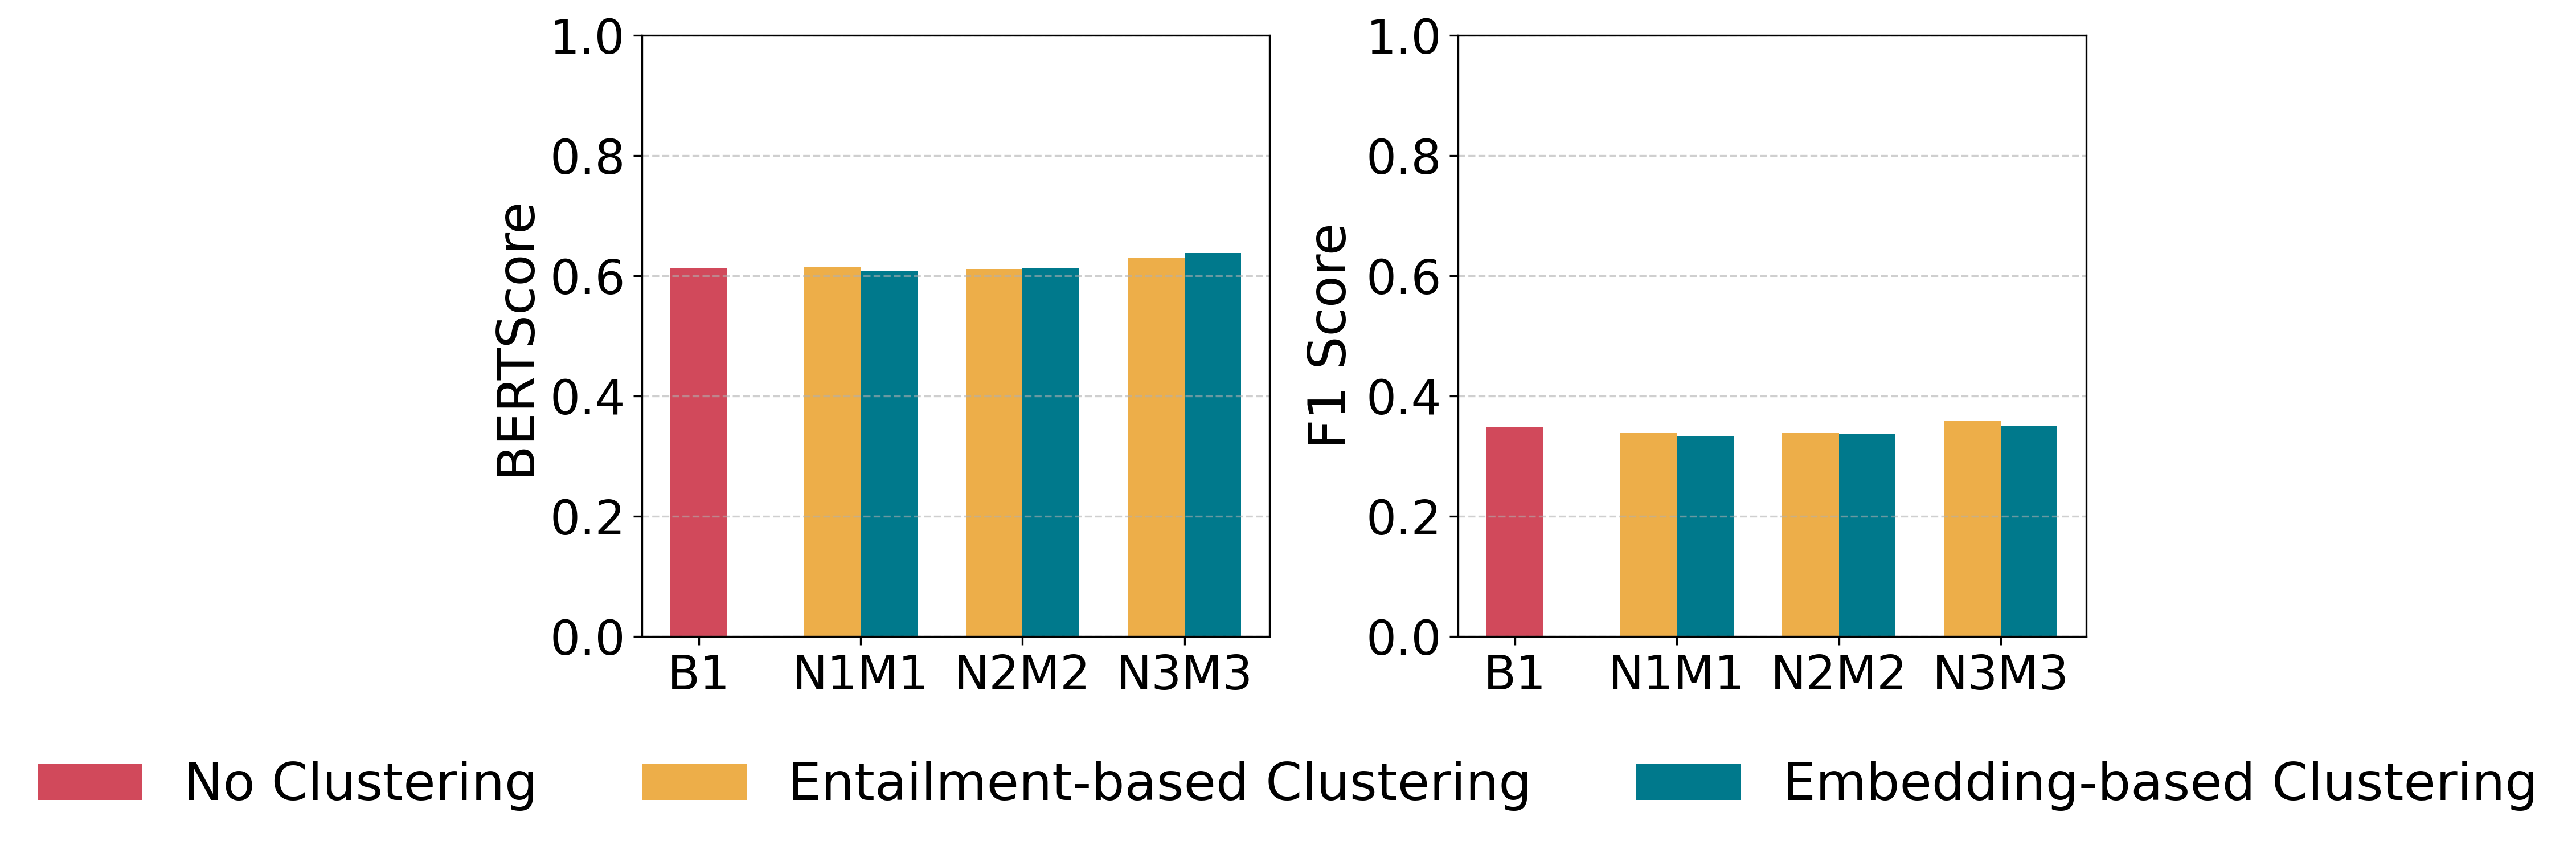

In [14]:
metric_configs = [
        ("_bert_score_results.jsonl", None, "similarity", "BERTScore"),
        ("_f1_results.jsonl", None, "f1", "F1 Score")
    ]
create_1x4_plot_row(metric_configs)

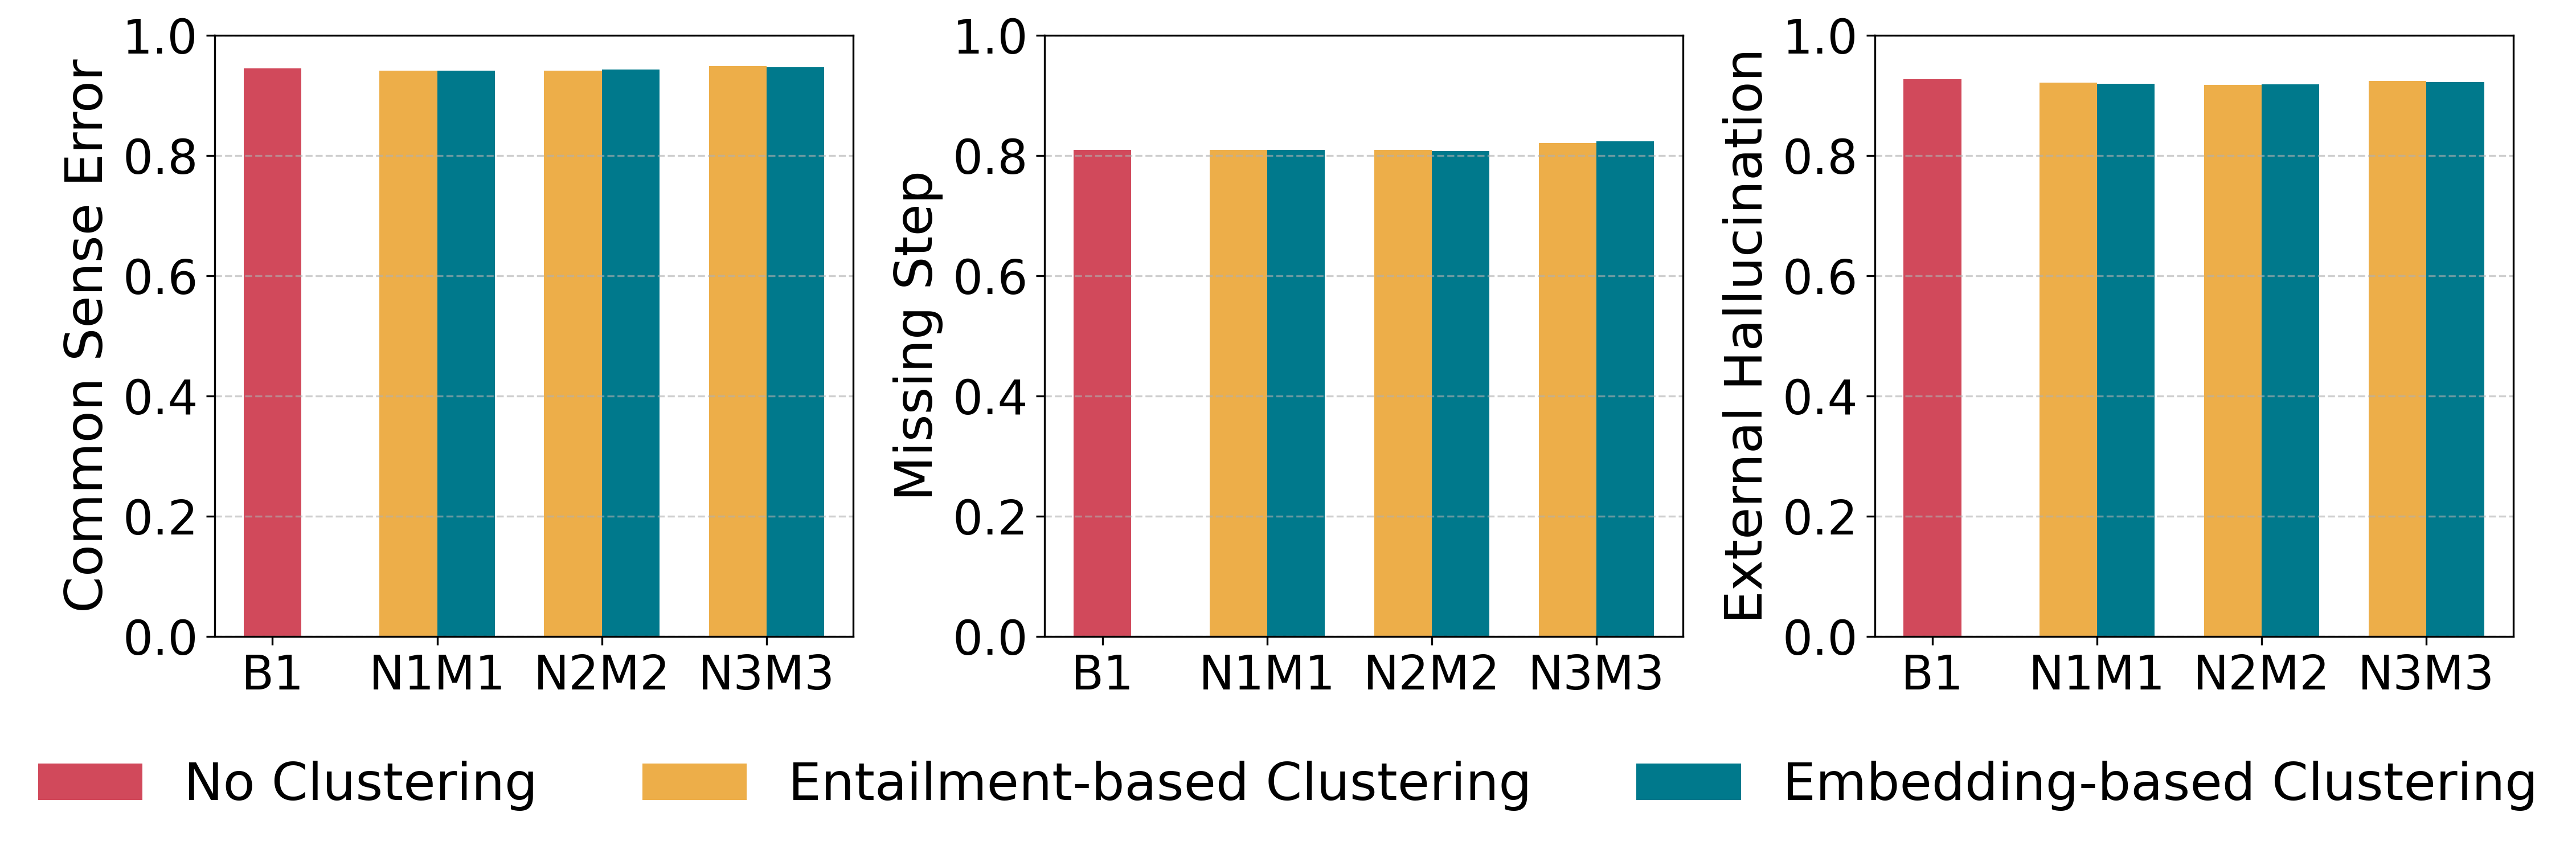

In [16]:
metric_configs = [
        ("_roscoe_results.tsv", "common_sense_error", None, "Common Sense Error"),
        ("_roscoe_results.tsv", "missing_step", None, "Missing Step"),
    ("_roscoe_results.tsv", "external_hallucination", None, "External Hallucination"),
    ]
create_1x4_plot_row(metric_configs)